In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [4]:
def predict_grid(model, x1_key, x2_key, device, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)

    truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df["Prediction"] = preds
    df["Truth"] = truth
    #Get softmax score for blue
    df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [5]:
# Set up device
device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda:1 device NVIDIA TITAN V


In [6]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_ensemble_values = False
save_values = True
#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [7]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

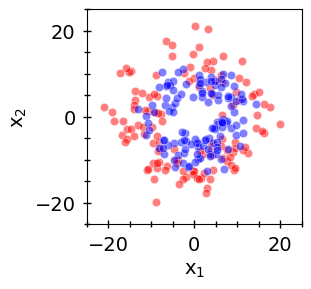

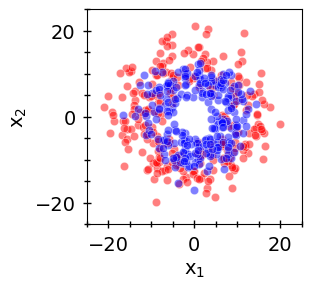

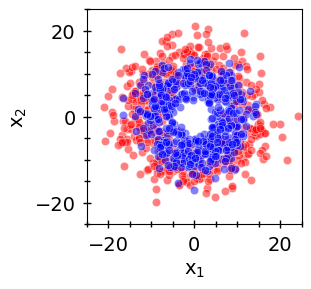

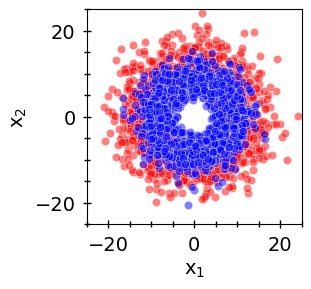

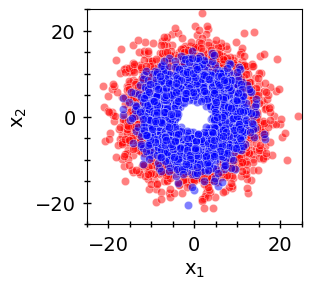

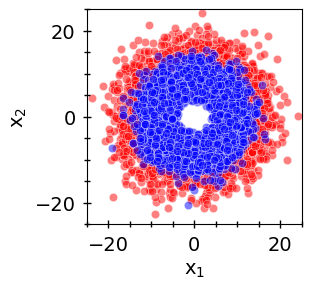

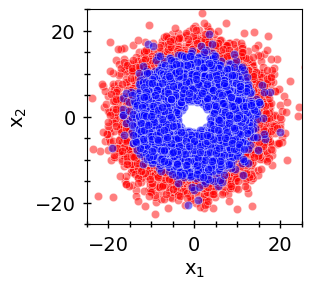

In [8]:
# Plot training data

#for i in range(len(n_data)):
    #fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), layout="constrained")
    #axs = plot_data(train_data[0:n_data[i]], ax, "")
    #fig.savefig(f"../fig/train_data_n_{n_data[i]}.pdf")

## Ensembling

In [9]:

def train_ensemble(n_ensemble, n_data):
    val_data_ensembles = pd.read_csv(f"../data/{valfile}.csv")
    test_data_ensembles = pd.read_csv(f"../data/{testfile}.csv")
    grid_ensembles = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))
    # Timer
    start = timer()
    print(f"Starting training of {n_ensemble} ensembles with {n_data} training points.")
    for i in range(n_ensemble):

        # Fresh validation dataframe
        val_data = pd.read_csv(f"../data/{valfile}.csv")
        val_data = word_to_int(val_data)

        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data], Y_train[0:n_data])

        # Create new model
        model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**9, epochs = 100, 
                                device = device, optimizer = optimizer, early_stopping=patience)
        
        # Predict on validation set
        truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
        preds_val = torch.argmax(logits_val, dim=-1).flatten()
        val_data_ensembles[f"Prediction_{i}"] = preds_val
        val_data_ensembles["Truth"] = truth_val
        #Get softmax score for blue
        val_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits_val, dim=-1)[:,1]

        # Predict on test set
        truth_test, logits_test = predict_classifier(model, test_dataset, 2, 100, device)
        preds_test = torch.argmax(logits_test, dim=-1).flatten()
        test_data_ensembles[f"Prediction_{i}"] = preds_test
        test_data_ensembles["Truth"] = truth_test
        #Get softmax score for blue
        test_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits_test, dim=-1)[:,1]

        # Predict for grid
        grid_df = predict_grid(model, x1_key, x2_key, device)
        grid_ensembles[f"x1"] = grid_df["x1"]
        grid_ensembles[f"x2"] = grid_df["x2"]
        grid_ensembles[f"r_x"] = grid_df["r_x"]
        grid_ensembles[f"a_x"] = grid_df["a_x"]
        grid_ensembles[f"Confidence_{i}"] = grid_df["Confidence"]
    end = timer()
    print("Training time: ", timedelta(seconds=end-start))
    return val_data_ensembles, test_data_ensembles, grid_ensembles

n_ensemble = 10

if load_ensemble_values==False:
    for i in range(len(n_data)):
        logloss_min = 1
        for j in tqdm(range(20)):
            val_df, test_df, grid_df = train_ensemble(n_ensemble, n_data[i])
            val_df["Confidence_avg"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
            val_df["Confidence_std"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
            val_df["Prediction_ensemble"] = 0
            mask = val_df["Confidence_avg"] > 0.5
            val_df.loc[mask, "Prediction_ensemble"] = 1

            ll = log_loss(val_df["class"], val_df["Confidence_avg"])
            preds = torch.Tensor(val_df["Confidence_avg"])
            target = torch.Tensor(val_df["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")

            if ll < logloss_min:
                print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
                logloss_min = ll

                val_data_ensembles = val_df
                test_data_ensembles = test_df
                grid_ensembles = grid_df

                test_data_ensembles["Confidence_avg"] = test_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                test_data_ensembles["Confidence_std"] = test_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
                test_data_ensembles["Prediction_ensemble"] = 0
                mask = test_data_ensembles["Confidence_avg"] > 0.5
                test_data_ensembles.loc[mask, "Prediction_ensemble"] = 1

                grid_ensembles["Confidence_avg"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                grid_ensembles["Confidence_std"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        # Save best prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            val_data_ensembles.to_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            test_data_ensembles.to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            grid_ensembles.to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")

    val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]

else:
    val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_best_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]


  0%|          | 0/20 [00:00<?, ?it/s]

Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 21.26it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:02<00:02, 22.57it/s]


Stopping training early at epoch 49


 69%|██████▉   | 69/100 [00:03<00:01, 22.72it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.60it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.35it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.61it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.52it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:02, 20.34it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.30it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.65it/s]


Stopping training early at epoch 69


  5%|▌         | 1/20 [00:35<11:20, 35.79s/it]

Training time:  0:00:35.717030
n_train = 250, logloss=0.6173703067038738, ECE= 0.10607440769672394
New best values: n_train = 250, logloss=0.6173703067038738, ECE= 0.10607440769672394
Starting training of 10 ensembles with 250 training points.


 79%|███████▉  | 79/100 [00:03<00:00, 22.38it/s]


Stopping training early at epoch 79


 49%|████▉     | 49/100 [00:02<00:02, 22.39it/s]


Stopping training early at epoch 49


 69%|██████▉   | 69/100 [00:03<00:01, 22.58it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.21it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:04<00:00, 22.07it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:03<00:01, 22.36it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.52it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.31it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:03<00:00, 22.59it/s]


Stopping training early at epoch 89


 10%|█         | 2/20 [01:14<11:12, 37.34s/it]

Training time:  0:00:38.374053
n_train = 250, logloss=0.6260569806906938, ECE= 0.10991727560758591
Starting training of 10 ensembles with 250 training points.


 99%|█████████▉| 99/100 [00:04<00:00, 22.60it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:04<00:00, 21.80it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:03<00:01, 22.20it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:04<00:00, 22.58it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:03<00:00, 22.53it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:03<00:01, 22.45it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.57it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.49it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 21.27it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:02<00:02, 22.38it/s]


Stopping training early at epoch 49


 15%|█▌        | 3/20 [01:53<10:49, 38.19s/it]

Training time:  0:00:39.154084
n_train = 250, logloss=0.6245847538950102, ECE= 0.10822945833206177
Starting training of 10 ensembles with 250 training points.


 79%|███████▉  | 79/100 [00:03<00:00, 22.52it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.50it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.51it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.51it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.12it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:04<00:00, 22.06it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:03<00:01, 22.57it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.74it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.82it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.34it/s]


Stopping training early at epoch 59


 20%|██        | 4/20 [02:29<09:59, 37.44s/it]

Training time:  0:00:36.256458
n_train = 250, logloss=0.6265027939998284, ECE= 0.11050589382648468
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 22.22it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 21.83it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.02it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 21.21it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:04<00:00, 22.51it/s]


Stopping training early at epoch 99


 99%|█████████▉| 99/100 [00:04<00:00, 22.52it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:03<00:00, 22.43it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.45it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:03<00:00, 22.27it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 21.81it/s]


Stopping training early at epoch 59


 25%|██▌       | 5/20 [03:08<09:27, 37.85s/it]

Training time:  0:00:38.530815
n_train = 250, logloss=0.6385634058961199, ECE= 0.11673031002283096
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 22.83it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.80it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.82it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.77it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.80it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:04<00:00, 22.25it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:03<00:00, 21.47it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.43it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.44it/s]


Stopping training early at epoch 59


 30%|███       | 6/20 [03:44<08:41, 37.21s/it]

Training time:  0:00:35.932539
n_train = 250, logloss=0.6256717378049163, ECE= 0.1106964573264122
Starting training of 10 ensembles with 250 training points.


 79%|███████▉  | 79/100 [00:03<00:00, 22.52it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.38it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.40it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 22.29it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 21.39it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.51it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:03<00:00, 22.26it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.44it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:02<00:02, 22.29it/s]


Stopping training early at epoch 49


 59%|█████▉    | 59/100 [00:02<00:01, 22.36it/s]


Stopping training early at epoch 59


 35%|███▌      | 7/20 [04:20<07:59, 36.86s/it]

Training time:  0:00:36.080095
n_train = 250, logloss=0.6274414163123196, ECE= 0.1123313307762146
Starting training of 10 ensembles with 250 training points.


 69%|██████▉   | 69/100 [00:03<00:01, 22.41it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.49it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 21.24it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.48it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.50it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:03<00:00, 22.58it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:03<00:01, 22.46it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.57it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:03<00:00, 22.29it/s]


Stopping training early at epoch 89


 40%|████      | 8/20 [04:59<07:31, 37.61s/it]

Training time:  0:00:39.182844
n_train = 250, logloss=0.6332212711194565, ECE= 0.1140824556350708
Starting training of 10 ensembles with 250 training points.


 79%|███████▉  | 79/100 [00:03<00:00, 22.52it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.49it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.44it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.51it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.24it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 21.25it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.55it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.54it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.46it/s]


Stopping training early at epoch 59


 45%|████▌     | 9/20 [05:33<06:42, 36.55s/it]

Training time:  0:00:34.180149
n_train = 250, logloss=0.6217558271817978, ECE= 0.10861480981111526
Starting training of 10 ensembles with 250 training points.


 69%|██████▉   | 69/100 [00:03<00:01, 22.54it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.06it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.25it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.75it/s]


Stopping training early at epoch 59


 99%|█████████▉| 99/100 [00:04<00:00, 22.31it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:03<00:01, 22.60it/s]


Stopping training early at epoch 69


 49%|████▉     | 49/100 [00:02<00:02, 21.98it/s]


Stopping training early at epoch 49


 79%|███████▉  | 79/100 [00:03<00:00, 22.40it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.13it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.38it/s]


Stopping training early at epoch 69


 50%|█████     | 10/20 [06:08<06:01, 36.11s/it]

Training time:  0:00:35.071939
n_train = 250, logloss=0.6261050464796283, ECE= 0.11147379130125046
Starting training of 10 ensembles with 250 training points.


 69%|██████▉   | 69/100 [00:03<00:01, 22.29it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.15it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 21.29it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:03<00:00, 21.99it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.37it/s]


Stopping training early at epoch 69


 49%|████▉     | 49/100 [00:02<00:02, 22.36it/s]


Stopping training early at epoch 49


 89%|████████▉ | 89/100 [00:03<00:00, 22.57it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:04<00:00, 22.59it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:04<00:00, 21.78it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:03<00:00, 22.55it/s]


Stopping training early at epoch 79


 55%|█████▌    | 11/20 [06:48<05:34, 37.12s/it]

Training time:  0:00:39.371403
n_train = 250, logloss=0.6365179826163522, ECE= 0.11693231016397476
Starting training of 10 ensembles with 250 training points.


 99%|█████████▉| 99/100 [00:04<00:00, 22.63it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:03<00:01, 22.49it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.51it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:04<00:00, 21.77it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:03<00:01, 22.52it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 21.98it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.27it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.59it/s]


Stopping training early at epoch 79


 60%|██████    | 12/20 [07:29<05:06, 38.28s/it]

Training time:  0:00:40.882298
n_train = 250, logloss=0.6390646840448152, ECE= 0.1148952767252922
Starting training of 10 ensembles with 250 training points.


 79%|███████▉  | 79/100 [00:03<00:00, 21.72it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.48it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.59it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.46it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 21.34it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 22.57it/s]


Stopping training early at epoch 79


 65%|██████▌   | 13/20 [08:07<04:27, 38.28s/it]

Training time:  0:00:38.222245
n_train = 250, logloss=0.6260781342641492, ECE= 0.11026864498853683
Starting training of 10 ensembles with 250 training points.


 79%|███████▉  | 79/100 [00:03<00:00, 22.59it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.53it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.63it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:03<00:00, 21.82it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:03<00:00, 22.56it/s]


Stopping training early at epoch 79


 49%|████▉     | 49/100 [00:02<00:02, 22.43it/s]


Stopping training early at epoch 49


 59%|█████▉    | 59/100 [00:02<00:01, 22.51it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 22.59it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.51it/s]


Stopping training early at epoch 59


 70%|███████   | 14/20 [08:45<03:48, 38.07s/it]

Training time:  0:00:37.553955
n_train = 250, logloss=0.634118804606182, ECE= 0.11321953684091568
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 21.35it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.34it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.54it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 21.68it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:04<00:00, 22.62it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:03<00:00, 22.58it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.46it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.38it/s]


Stopping training early at epoch 59


 75%|███████▌  | 15/20 [09:21<03:07, 37.47s/it]

Training time:  0:00:36.027318
n_train = 250, logloss=0.6204552722458425, ECE= 0.10814458131790161
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 22.43it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.51it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.59it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.48it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.52it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.61it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.44it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.48it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 21.36it/s]


Stopping training early at epoch 59


 80%|████████  | 16/20 [09:57<02:28, 37.16s/it]

Training time:  0:00:36.409883
n_train = 250, logloss=0.6295064232943401, ECE= 0.1132562905550003
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 22.46it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 22.56it/s]


Stopping training early at epoch 79


 49%|████▉     | 49/100 [00:02<00:02, 22.34it/s]


Stopping training early at epoch 49


 79%|███████▉  | 79/100 [00:03<00:00, 22.57it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.50it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 22.58it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 21.44it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.33it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 22.56it/s]


Stopping training early at epoch 79


 85%|████████▌ | 17/20 [10:32<01:49, 36.39s/it]

Training time:  0:00:34.549368
n_train = 250, logloss=0.6227642120110082, ECE= 0.10985087603330612
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 22.48it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.45it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.47it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:03<00:00, 21.68it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:03<00:00, 22.47it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:03<00:00, 22.43it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:03<00:00, 22.49it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:03<00:00, 21.65it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:03<00:00, 22.47it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:03<00:01, 22.38it/s]


Stopping training early at epoch 69


 90%|█████████ | 18/20 [11:09<01:13, 36.72s/it]

Training time:  0:00:37.432057
n_train = 250, logloss=0.6254804209737614, ECE= 0.10975410044193268
Starting training of 10 ensembles with 250 training points.


 59%|█████▉    | 59/100 [00:02<00:01, 22.35it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.40it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 22.38it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:03<00:01, 21.51it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.17it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.43it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:02<00:01, 22.37it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.25it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.38it/s]


Stopping training early at epoch 69


 49%|████▉     | 49/100 [00:02<00:02, 22.28it/s]


Stopping training early at epoch 49


 95%|█████████▌| 19/20 [11:42<00:35, 35.61s/it]

Training time:  0:00:33.004038
n_train = 250, logloss=0.6224666125086444, ECE= 0.10980814695358276
Starting training of 10 ensembles with 250 training points.


 89%|████████▉ | 89/100 [00:03<00:00, 22.47it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:04<00:00, 21.81it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:03<00:01, 22.53it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:03<00:00, 22.97it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:02<00:01, 22.84it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:02<00:02, 22.68it/s]


Stopping training early at epoch 49


 69%|██████▉   | 69/100 [00:03<00:01, 22.85it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:03<00:00, 21.78it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:03<00:00, 22.84it/s]


Stopping training early at epoch 79


100%|██████████| 20/20 [12:22<00:00, 37.11s/it]


Training time:  0:00:39.257298
n_train = 250, logloss=0.6359555064526039, ECE= 0.11680135130882263


  0%|          | 0/20 [00:00<?, ?it/s]

Starting training of 10 ensembles with 500 training points.


 99%|█████████▉| 99/100 [00:07<00:00, 12.98it/s]


Stopping training early at epoch 99


 59%|█████▉    | 59/100 [00:04<00:03, 12.93it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:04<00:03, 12.54it/s]


Stopping training early at epoch 59


 99%|█████████▉| 99/100 [00:07<00:00, 13.03it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:05<00:02, 12.64it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 13.00it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.99it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:06<00:00, 12.77it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:06<00:00, 13.03it/s]


Stopping training early at epoch 89


  5%|▌         | 1/20 [01:07<21:22, 67.49s/it]

Training time:  0:01:07.435361
n_train = 500, logloss=0.5513048701614506, ECE= 0.061467722058296204
New best values: n_train = 500, logloss=0.5513048701614506, ECE= 0.061467722058296204
Starting training of 10 ensembles with 500 training points.


 79%|███████▉  | 79/100 [00:06<00:01, 13.01it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:06<00:00, 12.81it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:08<00:00, 12.27it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:07<00:00, 12.37it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:06<00:01, 12.58it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:06<00:01, 12.25it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:07<00:00, 12.56it/s]


Stopping training early at epoch 99


 99%|█████████▉| 99/100 [00:08<00:00, 12.31it/s]


Stopping training early at epoch 99


 10%|█         | 2/20 [02:24<21:59, 73.28s/it]

Training time:  0:01:17.267194
n_train = 500, logloss=0.5433548737114499, ECE= 0.051295164972543716
New best values: n_train = 500, logloss=0.5433548737114499, ECE= 0.051295164972543716
Starting training of 10 ensembles with 500 training points.


 69%|██████▉   | 69/100 [00:05<00:02, 12.45it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.48it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.33it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:07<00:00, 12.48it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.38it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.03it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.40it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:04<00:03, 12.38it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.16it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.44it/s]


Stopping training early at epoch 69


 15%|█▌        | 3/20 [03:29<19:39, 69.35s/it]

Training time:  0:01:04.618307
n_train = 500, logloss=0.542683547521033, ECE= 0.05449628457427025
New best values: n_train = 500, logloss=0.542683547521033, ECE= 0.05449628457427025
Starting training of 10 ensembles with 500 training points.


 59%|█████▉    | 59/100 [00:04<00:03, 12.03it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.56it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:06<00:00, 12.74it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:07<00:00, 12.43it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:05<00:02, 12.51it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.69it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.61it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:07<00:00, 12.91it/s]


Stopping training early at epoch 99


 20%|██        | 4/20 [04:40<18:42, 70.18s/it]

Training time:  0:01:11.394067
n_train = 500, logloss=0.5446827877368731, ECE= 0.05459953844547272
Starting training of 10 ensembles with 500 training points.


 69%|██████▉   | 69/100 [00:05<00:02, 12.85it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.60it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:07<00:00, 12.51it/s]


Stopping training early at epoch 99


 59%|█████▉    | 59/100 [00:04<00:03, 12.76it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:07<00:00, 12.68it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.45it/s]


Stopping training early at epoch 89


 25%|██▌       | 5/20 [05:55<17:55, 71.72s/it]

Training time:  0:01:14.413841
n_train = 500, logloss=0.5449187300570177, ECE= 0.05180754140019417
Starting training of 10 ensembles with 500 training points.


 89%|████████▉ | 89/100 [00:06<00:00, 12.79it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:06<00:01, 12.55it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:06<00:00, 12.77it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:06<00:01, 12.71it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:04<00:03, 12.45it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:05<00:02, 12.64it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.22it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.56it/s]


Stopping training early at epoch 79


 30%|███       | 6/20 [07:04<16:32, 70.92s/it]

Training time:  0:01:09.328826
n_train = 500, logloss=0.5477492430223037, ECE= 0.05512896180152893
Starting training of 10 ensembles with 500 training points.


 89%|████████▉ | 89/100 [00:07<00:00, 12.54it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.05it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:07<00:00, 12.48it/s]


Stopping training early at epoch 99


 59%|█████▉    | 59/100 [00:04<00:03, 12.17it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:05<00:02, 12.41it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.65it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:07<00:00, 12.34it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.59it/s]


Stopping training early at epoch 69


 35%|███▌      | 7/20 [08:14<15:17, 70.61s/it]

Training time:  0:01:09.889306
n_train = 500, logloss=0.5423779608034364, ECE= 0.05329903960227966
New best values: n_train = 500, logloss=0.5423779608034364, ECE= 0.05329903960227966
Starting training of 10 ensembles with 500 training points.


 79%|███████▉  | 79/100 [00:06<00:01, 12.62it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:08<00:00, 12.35it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:05<00:02, 12.45it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.33it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.66it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.26it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:06<00:01, 12.50it/s]


Stopping training early at epoch 79


 40%|████      | 8/20 [09:26<14:13, 71.09s/it]

Training time:  0:01:12.068312
n_train = 500, logloss=0.5435153611940872, ECE= 0.054804883897304535
Starting training of 10 ensembles with 500 training points.


 79%|███████▉  | 79/100 [00:06<00:01, 12.51it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:06<00:01, 12.44it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:07<00:00, 12.49it/s]


Stopping training early at epoch 99


 99%|█████████▉| 99/100 [00:08<00:00, 12.37it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:05<00:02, 11.99it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:07<00:00, 12.65it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.75it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:04<00:03, 12.75it/s]


Stopping training early at epoch 59


 45%|████▌     | 9/20 [10:39<13:05, 71.42s/it]

Training time:  0:01:12.117833
n_train = 500, logloss=0.5470794587879424, ECE= 0.06089004874229431
Starting training of 10 ensembles with 500 training points.


 99%|█████████▉| 99/100 [00:07<00:00, 12.56it/s]


Stopping training early at epoch 99


 99%|█████████▉| 99/100 [00:07<00:00, 12.94it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:07<00:00, 12.43it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.71it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.43it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:04<00:03, 12.65it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:05<00:02, 12.69it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.59it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:06<00:01, 12.60it/s]


Stopping training early at epoch 79


 50%|█████     | 10/20 [11:51<11:56, 71.65s/it]

Training time:  0:01:12.101830
n_train = 500, logloss=0.5466045294871906, ECE= 0.053018949925899506
Starting training of 10 ensembles with 500 training points.


 89%|████████▉ | 89/100 [00:06<00:00, 12.85it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.54it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.49it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.69it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:07<00:00, 12.96it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.44it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:06<00:00, 12.77it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:06<00:00, 12.79it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:07<00:00, 12.56it/s]


Stopping training early at epoch 99


 59%|█████▉    | 59/100 [00:04<00:03, 12.73it/s]


Stopping training early at epoch 59


 55%|█████▌    | 11/20 [13:02<10:45, 71.69s/it]

Training time:  0:01:11.727025
n_train = 500, logloss=0.5470395899187862, ECE= 0.05245243012905121
Starting training of 10 ensembles with 500 training points.


 99%|█████████▉| 99/100 [00:07<00:00, 12.53it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.87it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.94it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.95it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:04<00:03, 12.90it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:07<00:00, 12.64it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.77it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:07<00:00, 12.78it/s]


Stopping training early at epoch 99


 60%|██████    | 12/20 [14:13<09:30, 71.30s/it]

Training time:  0:01:10.370922
n_train = 500, logloss=0.5429149639877638, ECE= 0.05350571125745773
Starting training of 10 ensembles with 500 training points.


 59%|█████▉    | 59/100 [00:04<00:03, 12.35it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.76it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:06<00:01, 12.48it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:04<00:03, 12.70it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.75it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:06<00:00, 12.76it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:07<00:00, 12.78it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.21it/s]


Stopping training early at epoch 79


 65%|██████▌   | 13/20 [15:23<08:15, 70.84s/it]

Training time:  0:01:09.729759
n_train = 500, logloss=0.544384673104799, ECE= 0.053842123597860336
Starting training of 10 ensembles with 500 training points.


 99%|█████████▉| 99/100 [00:07<00:00, 12.66it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.39it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:06<00:01, 12.80it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.75it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.42it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.76it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:07<00:00, 12.80it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:05<00:02, 12.47it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.67it/s]


Stopping training early at epoch 69


 70%|███████   | 14/20 [16:31<07:01, 70.19s/it]

Training time:  0:01:08.661869
n_train = 500, logloss=0.5432008256378442, ECE= 0.052085693925619125
Starting training of 10 ensembles with 500 training points.


 59%|█████▉    | 59/100 [00:04<00:03, 12.60it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.66it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.11it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.68it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:07<00:00, 12.65it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.73it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:07<00:00, 12.49it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:07<00:00, 12.59it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:07<00:00, 12.66it/s]


Stopping training early at epoch 89


 75%|███████▌  | 15/20 [17:41<05:49, 69.90s/it]

Training time:  0:01:09.166533
n_train = 500, logloss=0.5451673854943306, ECE= 0.05946294963359833
Starting training of 10 ensembles with 500 training points.


 99%|█████████▉| 99/100 [00:07<00:00, 12.74it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:07<00:00, 12.49it/s]


Stopping training early at epoch 89


 99%|█████████▉| 99/100 [00:07<00:00, 12.72it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.38it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:04<00:03, 12.53it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.77it/s]


Stopping training early at epoch 79


 80%|████████  | 16/20 [18:57<04:47, 71.76s/it]

Training time:  0:01:16.045060
n_train = 500, logloss=0.5464214690770365, ECE= 0.05610990151762962
Starting training of 10 ensembles with 500 training points.


 59%|█████▉    | 59/100 [00:04<00:03, 12.61it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:04<00:03, 12.44it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:04<00:03, 12.69it/s]


Stopping training early at epoch 59


 99%|█████████▉| 99/100 [00:07<00:00, 12.38it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.62it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:07<00:00, 12.50it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:06<00:00, 12.93it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.70it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.47it/s]


Stopping training early at epoch 79


 85%|████████▌ | 17/20 [20:03<03:30, 70.14s/it]

Training time:  0:01:06.333858
n_train = 500, logloss=0.5465728041035814, ECE= 0.05263843759894371
Starting training of 10 ensembles with 500 training points.


 59%|█████▉    | 59/100 [00:04<00:03, 12.73it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:06<00:00, 12.77it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.77it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:07<00:00, 12.55it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:06<00:00, 12.82it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:04<00:03, 12.73it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:05<00:02, 12.46it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:04<00:03, 12.76it/s]


Stopping training early at epoch 59


 90%|█████████ | 18/20 [21:09<02:17, 68.97s/it]

Training time:  0:01:06.179565
n_train = 500, logloss=0.5426555424928889, ECE= 0.04886724054813385
Starting training of 10 ensembles with 500 training points.


 89%|████████▉ | 89/100 [00:06<00:00, 12.80it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:05<00:02, 12.73it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:07<00:00, 12.58it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:06<00:01, 12.78it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:07<00:00, 12.57it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:06<00:00, 12.80it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:06<00:01, 12.56it/s]


Stopping training early at epoch 79


 95%|█████████▌| 19/20 [22:23<01:10, 70.50s/it]

Training time:  0:01:14.033062
n_train = 500, logloss=0.5470277786407857, ECE= 0.05552701652050018
Starting training of 10 ensembles with 500 training points.


 99%|█████████▉| 99/100 [00:07<00:00, 12.59it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.73it/s]


Stopping training early at epoch 79


 99%|█████████▉| 99/100 [00:07<00:00, 12.82it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.51it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.73it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:06<00:01, 12.76it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:07<00:00, 12.55it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:06<00:01, 12.79it/s]


Stopping training early at epoch 79


100%|██████████| 20/20 [23:36<00:00, 70.85s/it]


Training time:  0:01:13.082481
n_train = 500, logloss=0.5460253549210552, ECE= 0.049966126680374146


  0%|          | 0/20 [00:00<?, ?it/s]

Starting training of 10 ensembles with 1000 training points.


 69%|██████▉   | 69/100 [00:10<00:04,  6.32it/s]


Stopping training early at epoch 69


 94%|█████████▍| 94/100 [00:14<00:00,  6.37it/s]


Stopping training early at epoch 94


 64%|██████▍   | 64/100 [00:10<00:05,  6.30it/s]


Stopping training early at epoch 64


 74%|███████▍  | 74/100 [00:11<00:04,  6.34it/s]


Stopping training early at epoch 74


 54%|█████▍    | 54/100 [00:08<00:07,  6.36it/s]


Stopping training early at epoch 54


 79%|███████▉  | 79/100 [00:12<00:03,  6.35it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:13<00:01,  6.36it/s]


Stopping training early at epoch 89


 49%|████▉     | 49/100 [00:07<00:08,  6.35it/s]


Stopping training early at epoch 49


  5%|▌         | 1/20 [02:05<39:50, 125.81s/it]

Training time:  0:02:05.749053
n_train = 1000, logloss=0.5278599501250529, ECE= 0.035284023731946945
New best values: n_train = 1000, logloss=0.5278599501250529, ECE= 0.035284023731946945
Starting training of 10 ensembles with 1000 training points.


 69%|██████▉   | 69/100 [00:11<00:05,  6.19it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:10<00:04,  6.30it/s]


Stopping training early at epoch 69


 54%|█████▍    | 54/100 [00:08<00:07,  6.35it/s]


Stopping training early at epoch 54


 49%|████▉     | 49/100 [00:07<00:08,  6.25it/s]


Stopping training early at epoch 49


 69%|██████▉   | 69/100 [00:10<00:04,  6.40it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:12<00:03,  6.36it/s]


Stopping training early at epoch 79


 54%|█████▍    | 54/100 [00:08<00:07,  6.45it/s]


Stopping training early at epoch 54


 10%|█         | 2/20 [04:07<36:57, 123.21s/it]

Training time:  0:02:01.347170
n_train = 1000, logloss=0.5279574520426388, ECE= 0.03754093125462532
Starting training of 10 ensembles with 1000 training points.


 84%|████████▍ | 84/100 [00:13<00:02,  6.36it/s]


Stopping training early at epoch 84


 59%|█████▉    | 59/100 [00:09<00:06,  6.47it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:12<00:03,  6.41it/s]


Stopping training early at epoch 79


 64%|██████▍   | 64/100 [00:10<00:05,  6.31it/s]


Stopping training early at epoch 64


 79%|███████▉  | 79/100 [00:12<00:03,  6.34it/s]


Stopping training early at epoch 79


 54%|█████▍    | 54/100 [00:08<00:07,  6.31it/s]


Stopping training early at epoch 54


 79%|███████▉  | 79/100 [00:12<00:03,  6.45it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:09<00:06,  6.45it/s]


Stopping training early at epoch 59


 15%|█▌        | 3/20 [06:10<34:52, 123.12s/it]

Training time:  0:02:02.958095
n_train = 1000, logloss=0.5283348985426349, ECE= 0.036482591181993484
Starting training of 10 ensembles with 1000 training points.


 54%|█████▍    | 54/100 [00:08<00:07,  6.34it/s]


Stopping training early at epoch 54


 74%|███████▍  | 74/100 [00:11<00:04,  6.29it/s]


Stopping training early at epoch 74


 79%|███████▉  | 79/100 [00:12<00:03,  6.30it/s]


Stopping training early at epoch 79


 89%|████████▉ | 89/100 [00:14<00:01,  6.33it/s]


Stopping training early at epoch 89


 74%|███████▍  | 74/100 [00:11<00:04,  6.33it/s]


Stopping training early at epoch 74


 69%|██████▉   | 69/100 [00:10<00:04,  6.38it/s]


Stopping training early at epoch 69


 74%|███████▍  | 74/100 [00:11<00:04,  6.31it/s]


Stopping training early at epoch 74


 94%|█████████▍| 94/100 [00:14<00:00,  6.37it/s]


Stopping training early at epoch 94


 59%|█████▉    | 59/100 [00:09<00:06,  6.45it/s]


Stopping training early at epoch 59


 20%|██        | 4/20 [08:15<33:02, 123.90s/it]

Training time:  0:02:05.063161
n_train = 1000, logloss=0.5292676786925599, ECE= 0.03033849410712719
Starting training of 10 ensembles with 1000 training points.


 79%|███████▉  | 79/100 [00:12<00:03,  6.37it/s]


Stopping training early at epoch 79


 74%|███████▍  | 74/100 [00:11<00:04,  6.29it/s]


Stopping training early at epoch 74


 94%|█████████▍| 94/100 [00:14<00:00,  6.38it/s]


Stopping training early at epoch 94


 69%|██████▉   | 69/100 [00:10<00:04,  6.40it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:09<00:06,  6.46it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:09<00:06,  6.38it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:14<00:01,  6.35it/s]


Stopping training early at epoch 89


 25%|██▌       | 5/20 [10:28<31:49, 127.27s/it]

Training time:  0:02:13.199562
n_train = 1000, logloss=0.5291524485838215, ECE= 0.04040173441171646
Starting training of 10 ensembles with 1000 training points.


 84%|████████▍ | 84/100 [00:13<00:02,  6.42it/s]


Stopping training early at epoch 84


 69%|██████▉   | 69/100 [00:10<00:04,  6.38it/s]


Stopping training early at epoch 69


 54%|█████▍    | 54/100 [00:08<00:07,  6.42it/s]


Stopping training early at epoch 54


 49%|████▉     | 49/100 [00:07<00:07,  6.38it/s]


Stopping training early at epoch 49


 54%|█████▍    | 54/100 [00:08<00:07,  6.26it/s]


Stopping training early at epoch 54


 69%|██████▉   | 69/100 [00:10<00:04,  6.33it/s]


Stopping training early at epoch 69


 74%|███████▍  | 74/100 [00:11<00:04,  6.37it/s]


Stopping training early at epoch 74


 99%|█████████▉| 99/100 [00:15<00:00,  6.38it/s]


Stopping training early at epoch 99


 30%|███       | 6/20 [12:30<29:17, 125.53s/it]

Training time:  0:02:02.082330
n_train = 1000, logloss=0.527254097021663, ECE= 0.03354249149560928
New best values: n_train = 1000, logloss=0.527254097021663, ECE= 0.03354249149560928
Starting training of 10 ensembles with 1000 training points.


 64%|██████▍   | 64/100 [00:10<00:05,  6.14it/s]


Stopping training early at epoch 64


 74%|███████▍  | 74/100 [00:12<00:04,  6.09it/s]


Stopping training early at epoch 74


 84%|████████▍ | 84/100 [00:13<00:02,  6.11it/s]


Stopping training early at epoch 84


 49%|████▉     | 49/100 [00:07<00:08,  6.20it/s]


Stopping training early at epoch 49


 74%|███████▍  | 74/100 [00:12<00:04,  6.12it/s]


Stopping training early at epoch 74


 69%|██████▉   | 69/100 [00:11<00:05,  6.01it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:11<00:04,  6.27it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:11<00:05,  6.13it/s]


Stopping training early at epoch 69


 35%|███▌      | 7/20 [14:37<27:18, 126.04s/it]

Training time:  0:02:07.046619
n_train = 1000, logloss=0.5265983941574248, ECE= 0.032059554010629654
New best values: n_train = 1000, logloss=0.5265983941574248, ECE= 0.032059554010629654
Starting training of 10 ensembles with 1000 training points.


 49%|████▉     | 49/100 [00:07<00:08,  6.13it/s]


Stopping training early at epoch 49


 69%|██████▉   | 69/100 [00:11<00:04,  6.21it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:11<00:04,  6.25it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:15<00:00,  6.29it/s]


Stopping training early at epoch 99


 89%|████████▉ | 89/100 [00:14<00:01,  6.30it/s]


Stopping training early at epoch 89


 84%|████████▍ | 84/100 [00:13<00:02,  6.13it/s]


Stopping training early at epoch 84


 74%|███████▍  | 74/100 [00:11<00:04,  6.18it/s]


Stopping training early at epoch 74


 49%|████▉     | 49/100 [00:07<00:08,  6.18it/s]


Stopping training early at epoch 49


 94%|█████████▍| 94/100 [00:15<00:00,  6.21it/s]


Stopping training early at epoch 94


 40%|████      | 8/20 [16:47<25:25, 127.14s/it]

Training time:  0:02:09.427501
n_train = 1000, logloss=0.5267475994960361, ECE= 0.03106198087334633
Starting training of 10 ensembles with 1000 training points.


 54%|█████▍    | 54/100 [00:08<00:07,  6.26it/s]


Stopping training early at epoch 54


 74%|███████▍  | 74/100 [00:11<00:04,  6.24it/s]


Stopping training early at epoch 74


 79%|███████▉  | 79/100 [00:12<00:03,  6.22it/s]


Stopping training early at epoch 79


 94%|█████████▍| 94/100 [00:15<00:00,  6.26it/s]


Stopping training early at epoch 94


 54%|█████▍    | 54/100 [00:08<00:07,  6.24it/s]


Stopping training early at epoch 54


 64%|██████▍   | 64/100 [00:10<00:05,  6.08it/s]


Stopping training early at epoch 64


 69%|██████▉   | 69/100 [00:10<00:04,  6.30it/s]


Stopping training early at epoch 69


 45%|████▌     | 9/20 [18:58<23:31, 128.32s/it]

Training time:  0:02:10.879530
n_train = 1000, logloss=0.5268073301477652, ECE= 0.0345492884516716
Starting training of 10 ensembles with 1000 training points.


 64%|██████▍   | 64/100 [00:10<00:05,  6.18it/s]


Stopping training early at epoch 64


 79%|███████▉  | 79/100 [00:12<00:03,  6.15it/s]


Stopping training early at epoch 79


 74%|███████▍  | 74/100 [00:12<00:04,  6.14it/s]


Stopping training early at epoch 74


 64%|██████▍   | 64/100 [00:10<00:05,  6.30it/s]


Stopping training early at epoch 64


 54%|█████▍    | 54/100 [00:08<00:07,  6.22it/s]


Stopping training early at epoch 54


 94%|█████████▍| 94/100 [00:14<00:00,  6.27it/s]


Stopping training early at epoch 94


 74%|███████▍  | 74/100 [00:12<00:04,  6.11it/s]


Stopping training early at epoch 74


 59%|█████▉    | 59/100 [00:09<00:06,  6.09it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:12<00:03,  6.17it/s]


Stopping training early at epoch 79


 50%|█████     | 10/20 [21:02<21:11, 127.17s/it]

Training time:  0:02:04.305872
n_train = 1000, logloss=0.5260057151421271, ECE= 0.03200493007898331
New best values: n_train = 1000, logloss=0.5260057151421271, ECE= 0.03200493007898331
Starting training of 10 ensembles with 1000 training points.


 64%|██████▍   | 64/100 [00:10<00:05,  6.06it/s]


Stopping training early at epoch 64


 59%|█████▉    | 59/100 [00:09<00:06,  6.15it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:09<00:06,  6.23it/s]


Stopping training early at epoch 59


 89%|████████▉ | 89/100 [00:13<00:01,  6.42it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:14<00:01,  6.36it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:13<00:01,  6.45it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:12<00:03,  6.38it/s]


Stopping training early at epoch 79


 55%|█████▌    | 11/20 [23:17<19:26, 129.57s/it]

Training time:  0:02:14.945858
n_train = 1000, logloss=0.5317091073984455, ECE= 0.03510987013578415
Starting training of 10 ensembles with 1000 training points.


 49%|████▉     | 49/100 [00:07<00:07,  6.40it/s]


Stopping training early at epoch 49


 59%|█████▉    | 59/100 [00:09<00:06,  6.37it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:10<00:04,  6.35it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:15<00:00,  6.29it/s]


Stopping training early at epoch 99


 59%|█████▉    | 59/100 [00:09<00:06,  6.35it/s]


Stopping training early at epoch 59


 54%|█████▍    | 54/100 [00:08<00:07,  6.39it/s]


Stopping training early at epoch 54


 64%|██████▍   | 64/100 [00:10<00:05,  6.33it/s]


Stopping training early at epoch 64


 74%|███████▍  | 74/100 [00:11<00:04,  6.25it/s]


Stopping training early at epoch 74


 99%|█████████▉| 99/100 [00:15<00:00,  6.40it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:10<00:04,  6.37it/s]


Stopping training early at epoch 69


 60%|██████    | 12/20 [25:12<16:39, 124.91s/it]

Training time:  0:01:54.186634
n_train = 1000, logloss=0.525350254291686, ECE= 0.03262326493859291
New best values: n_train = 1000, logloss=0.525350254291686, ECE= 0.03262326493859291
Starting training of 10 ensembles with 1000 training points.


 74%|███████▍  | 74/100 [00:11<00:04,  6.33it/s]


Stopping training early at epoch 74


 99%|█████████▉| 99/100 [00:15<00:00,  6.42it/s]


Stopping training early at epoch 99


 69%|██████▉   | 69/100 [00:10<00:04,  6.32it/s]


Stopping training early at epoch 69


 74%|███████▍  | 74/100 [00:11<00:04,  6.40it/s]


Stopping training early at epoch 74


 74%|███████▍  | 74/100 [00:11<00:04,  6.34it/s]


Stopping training early at epoch 74


 64%|██████▍   | 64/100 [00:10<00:05,  6.26it/s]


Stopping training early at epoch 64


 89%|████████▉ | 89/100 [00:13<00:01,  6.38it/s]


Stopping training early at epoch 89


 64%|██████▍   | 64/100 [00:10<00:05,  6.26it/s]


Stopping training early at epoch 64


 79%|███████▉  | 79/100 [00:12<00:03,  6.32it/s]


Stopping training early at epoch 79


 65%|██████▌   | 13/20 [27:20<14:41, 125.94s/it]

Training time:  0:02:08.279298
n_train = 1000, logloss=0.5271420700124754, ECE= 0.03485073894262314
Starting training of 10 ensembles with 1000 training points.


 59%|█████▉    | 59/100 [00:09<00:06,  6.33it/s]


Stopping training early at epoch 59


 74%|███████▍  | 74/100 [00:11<00:04,  6.30it/s]


Stopping training early at epoch 74


 54%|█████▍    | 54/100 [00:08<00:07,  6.44it/s]


Stopping training early at epoch 54


 84%|████████▍ | 84/100 [00:13<00:02,  6.43it/s]


Stopping training early at epoch 84


 79%|███████▉  | 79/100 [00:12<00:03,  6.41it/s]


Stopping training early at epoch 79


 64%|██████▍   | 64/100 [00:10<00:05,  6.40it/s]


Stopping training early at epoch 64


 89%|████████▉ | 89/100 [00:14<00:01,  6.35it/s]


Stopping training early at epoch 89


 89%|████████▉ | 89/100 [00:13<00:01,  6.48it/s]


Stopping training early at epoch 89


 69%|██████▉   | 69/100 [00:10<00:04,  6.43it/s]


Stopping training early at epoch 69


 70%|███████   | 14/20 [29:23<12:30, 125.15s/it]

Training time:  0:02:03.262667
n_train = 1000, logloss=0.5262519412076776, ECE= 0.037173081189394
Starting training of 10 ensembles with 1000 training points.


 49%|████▉     | 49/100 [00:07<00:08,  6.34it/s]


Stopping training early at epoch 49


 54%|█████▍    | 54/100 [00:08<00:07,  6.37it/s]


Stopping training early at epoch 54


 64%|██████▍   | 64/100 [00:10<00:05,  6.37it/s]


Stopping training early at epoch 64


 89%|████████▉ | 89/100 [00:13<00:01,  6.37it/s]


Stopping training early at epoch 89


 54%|█████▍    | 54/100 [00:08<00:07,  6.39it/s]


Stopping training early at epoch 54


 75%|███████▌  | 15/20 [31:33<10:33, 126.63s/it]

Training time:  0:02:10.027666
n_train = 1000, logloss=0.5279842831734515, ECE= 0.04013947769999504
Starting training of 10 ensembles with 1000 training points.


 94%|█████████▍| 94/100 [00:14<00:00,  6.43it/s]


Stopping training early at epoch 94


 99%|█████████▉| 99/100 [00:15<00:00,  6.42it/s]


Stopping training early at epoch 99


 64%|██████▍   | 64/100 [00:09<00:05,  6.47it/s]


Stopping training early at epoch 64


 99%|█████████▉| 99/100 [00:15<00:00,  6.44it/s]


Stopping training early at epoch 99


 74%|███████▍  | 74/100 [00:11<00:04,  6.36it/s]


Stopping training early at epoch 74


 99%|█████████▉| 99/100 [00:15<00:00,  6.40it/s]


Stopping training early at epoch 99


 54%|█████▍    | 54/100 [00:08<00:07,  6.44it/s]


Stopping training early at epoch 54


 54%|█████▍    | 54/100 [00:08<00:07,  6.38it/s]


Stopping training early at epoch 54


 80%|████████  | 16/20 [33:48<08:36, 129.13s/it]

Training time:  0:02:14.880418
n_train = 1000, logloss=0.5270173362576586, ECE= 0.034659795463085175
Starting training of 10 ensembles with 1000 training points.


 64%|██████▍   | 64/100 [00:09<00:05,  6.48it/s]


Stopping training early at epoch 64


 89%|████████▉ | 89/100 [00:13<00:01,  6.46it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:09<00:06,  6.39it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:12<00:03,  6.45it/s]


Stopping training early at epoch 79


 54%|█████▍    | 54/100 [00:08<00:07,  6.47it/s]


Stopping training early at epoch 54


 79%|███████▉  | 79/100 [00:12<00:03,  6.43it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:09<00:06,  6.48it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:12<00:03,  6.44it/s]


Stopping training early at epoch 79


 85%|████████▌ | 17/20 [35:51<06:21, 127.13s/it]

Training time:  0:02:02.415333
n_train = 1000, logloss=0.524901088139728, ECE= 0.03203285112977028
New best values: n_train = 1000, logloss=0.524901088139728, ECE= 0.03203285112977028
Starting training of 10 ensembles with 1000 training points.


 99%|█████████▉| 99/100 [00:15<00:00,  6.48it/s]


Stopping training early at epoch 99


 49%|████▉     | 49/100 [00:07<00:08,  6.35it/s]


Stopping training early at epoch 49


 79%|███████▉  | 79/100 [00:12<00:03,  6.45it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:09<00:06,  6.48it/s]


Stopping training early at epoch 59


 64%|██████▍   | 64/100 [00:10<00:05,  6.39it/s]


Stopping training early at epoch 64


 49%|████▉     | 49/100 [00:07<00:07,  6.38it/s]


Stopping training early at epoch 49


 89%|████████▉ | 89/100 [00:13<00:01,  6.38it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:12<00:03,  6.50it/s]


Stopping training early at epoch 79


 64%|██████▍   | 64/100 [00:09<00:05,  6.45it/s]


Stopping training early at epoch 64


 90%|█████████ | 18/20 [37:49<04:08, 124.46s/it]

Training time:  0:01:58.213591
n_train = 1000, logloss=0.5258961508838109, ECE= 0.03429434821009636
Starting training of 10 ensembles with 1000 training points.


 84%|████████▍ | 84/100 [00:12<00:02,  6.52it/s]


Stopping training early at epoch 84


 84%|████████▍ | 84/100 [00:13<00:02,  6.32it/s]


Stopping training early at epoch 84


 74%|███████▍  | 74/100 [00:11<00:04,  6.36it/s]


Stopping training early at epoch 74


 69%|██████▉   | 69/100 [00:10<00:04,  6.42it/s]


Stopping training early at epoch 69


 64%|██████▍   | 64/100 [00:10<00:05,  6.33it/s]


Stopping training early at epoch 64


 89%|████████▉ | 89/100 [00:13<00:01,  6.39it/s]


Stopping training early at epoch 89


 84%|████████▍ | 84/100 [00:13<00:02,  6.38it/s]


Stopping training early at epoch 84


 89%|████████▉ | 89/100 [00:13<00:01,  6.45it/s]


Stopping training early at epoch 89


 54%|█████▍    | 54/100 [00:08<00:07,  6.30it/s]


Stopping training early at epoch 54


 95%|█████████▌| 19/20 [39:57<02:05, 125.61s/it]

Training time:  0:02:08.230885
n_train = 1000, logloss=0.531333733914008, ECE= 0.0315176360309124
Starting training of 10 ensembles with 1000 training points.


 54%|█████▍    | 54/100 [00:08<00:07,  6.31it/s]


Stopping training early at epoch 54


 79%|███████▉  | 79/100 [00:12<00:03,  6.38it/s]


Stopping training early at epoch 79


 74%|███████▍  | 74/100 [00:11<00:04,  6.44it/s]


Stopping training early at epoch 74


 99%|█████████▉| 99/100 [00:15<00:00,  6.40it/s]


Stopping training early at epoch 99


 74%|███████▍  | 74/100 [00:11<00:04,  6.36it/s]


Stopping training early at epoch 74


 64%|██████▍   | 64/100 [00:09<00:05,  6.41it/s]


Stopping training early at epoch 64


 59%|█████▉    | 59/100 [00:09<00:06,  6.32it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:09<00:06,  6.32it/s]


Stopping training early at epoch 59


 84%|████████▍ | 84/100 [00:13<00:02,  6.38it/s]


Stopping training early at epoch 84


100%|██████████| 20/20 [41:59<00:00, 125.96s/it]


Training time:  0:02:01.497579
n_train = 1000, logloss=0.5281034382204199, ECE= 0.03412414342164993


  0%|          | 0/20 [00:00<?, ?it/s]

Starting training of 10 ensembles with 2000 training points.


 62%|██████▏   | 62/100 [00:19<00:11,  3.23it/s]


Stopping training early at epoch 62


 52%|█████▏    | 52/100 [00:16<00:15,  3.18it/s]


Stopping training early at epoch 52


 62%|██████▏   | 62/100 [00:19<00:11,  3.23it/s]


Stopping training early at epoch 62


 52%|█████▏    | 52/100 [00:16<00:15,  3.17it/s]


Stopping training early at epoch 52


 72%|███████▏  | 72/100 [00:22<00:08,  3.22it/s]


Stopping training early at epoch 72


 52%|█████▏    | 52/100 [00:16<00:15,  3.20it/s]


Stopping training early at epoch 52


 52%|█████▏    | 52/100 [00:16<00:14,  3.20it/s]


Stopping training early at epoch 52


 77%|███████▋  | 77/100 [00:24<00:07,  3.21it/s]


Stopping training early at epoch 77


 64%|██████▍   | 64/100 [00:19<00:11,  3.21it/s]


Stopping training early at epoch 64


  5%|▌         | 1/20 [03:25<1:04:59, 205.24s/it]

Training time:  0:03:25.175683
n_train = 2000, logloss=0.5232617020080744, ECE= 0.03371530771255493
New best values: n_train = 2000, logloss=0.5232617020080744, ECE= 0.03371530771255493
Starting training of 10 ensembles with 2000 training points.


 77%|███████▋  | 77/100 [00:23<00:07,  3.22it/s]


Stopping training early at epoch 77


 49%|████▉     | 49/100 [00:15<00:15,  3.20it/s]


Stopping training early at epoch 49


 52%|█████▏    | 52/100 [00:16<00:14,  3.20it/s]


Stopping training early at epoch 52


 77%|███████▋  | 77/100 [00:23<00:07,  3.22it/s]


Stopping training early at epoch 77


 62%|██████▏   | 62/100 [00:19<00:11,  3.18it/s]


Stopping training early at epoch 62


 62%|██████▏   | 62/100 [00:19<00:11,  3.25it/s]


Stopping training early at epoch 62


 72%|███████▏  | 72/100 [00:22<00:08,  3.19it/s]


Stopping training early at epoch 72


 44%|████▍     | 44/100 [00:13<00:17,  3.16it/s]


Stopping training early at epoch 44


 79%|███████▉  | 79/100 [00:24<00:06,  3.23it/s]


Stopping training early at epoch 79


 10%|█         | 2/20 [06:59<1:03:06, 210.36s/it]

Training time:  0:03:33.890983
n_train = 2000, logloss=0.5218768759742091, ECE= 0.03447088599205017
New best values: n_train = 2000, logloss=0.5218768759742091, ECE= 0.03447088599205017
Starting training of 10 ensembles with 2000 training points.


 79%|███████▉  | 79/100 [00:24<00:06,  3.24it/s]


Stopping training early at epoch 79


 74%|███████▍  | 74/100 [00:22<00:08,  3.23it/s]


Stopping training early at epoch 74


 67%|██████▋   | 67/100 [00:20<00:10,  3.23it/s]


Stopping training early at epoch 67


 47%|████▋     | 47/100 [00:15<00:16,  3.13it/s]


Stopping training early at epoch 47


 57%|█████▋    | 57/100 [00:18<00:13,  3.15it/s]


Stopping training early at epoch 57


 44%|████▍     | 44/100 [00:13<00:17,  3.15it/s]


Stopping training early at epoch 44


 64%|██████▍   | 64/100 [00:19<00:11,  3.21it/s]


Stopping training early at epoch 64


 64%|██████▍   | 64/100 [00:19<00:11,  3.22it/s]


Stopping training early at epoch 64


 89%|████████▉ | 89/100 [00:27<00:03,  3.21it/s]


Stopping training early at epoch 89


 79%|███████▉  | 79/100 [00:24<00:06,  3.20it/s]


Stopping training early at epoch 79


 15%|█▌        | 3/20 [10:31<59:50, 211.20s/it]  

Training time:  0:03:32.126921
n_train = 2000, logloss=0.5210631910754842, ECE= 0.030919190496206284
New best values: n_train = 2000, logloss=0.5210631910754842, ECE= 0.030919190496206284
Starting training of 10 ensembles with 2000 training points.


 52%|█████▏    | 52/100 [00:16<00:15,  3.17it/s]


Stopping training early at epoch 52


 79%|███████▉  | 79/100 [00:24<00:06,  3.25it/s]


Stopping training early at epoch 79


 57%|█████▋    | 57/100 [00:17<00:13,  3.24it/s]


Stopping training early at epoch 57


 84%|████████▍ | 84/100 [00:25<00:04,  3.24it/s]


Stopping training early at epoch 84


 62%|██████▏   | 62/100 [00:19<00:11,  3.17it/s]


Stopping training early at epoch 62


 84%|████████▍ | 84/100 [00:26<00:04,  3.21it/s]


Stopping training early at epoch 84


 99%|█████████▉| 99/100 [00:30<00:00,  3.23it/s]


Stopping training early at epoch 99


 72%|███████▏  | 72/100 [00:22<00:08,  3.23it/s]


Stopping training early at epoch 72


 54%|█████▍    | 54/100 [00:17<00:14,  3.15it/s]


Stopping training early at epoch 54


 84%|████████▍ | 84/100 [00:25<00:04,  3.23it/s]


Stopping training early at epoch 84


 20%|██        | 4/20 [14:22<58:22, 218.93s/it]

Training time:  0:03:50.741703
n_train = 2000, logloss=0.524340766167291, ECE= 0.031929776072502136
Starting training of 10 ensembles with 2000 training points.


 67%|██████▋   | 67/100 [00:21<00:10,  3.13it/s]


Stopping training early at epoch 67


 62%|██████▏   | 62/100 [00:19<00:11,  3.23it/s]


Stopping training early at epoch 62


 64%|██████▍   | 64/100 [00:19<00:11,  3.25it/s]


Stopping training early at epoch 64


 69%|██████▉   | 69/100 [00:21<00:09,  3.21it/s]


Stopping training early at epoch 69


 82%|████████▏ | 82/100 [00:25<00:05,  3.27it/s]


Stopping training early at epoch 82


 62%|██████▏   | 62/100 [00:19<00:11,  3.19it/s]


Stopping training early at epoch 62


 97%|█████████▋| 97/100 [00:29<00:00,  3.24it/s]


Stopping training early at epoch 97


 77%|███████▋  | 77/100 [00:23<00:07,  3.23it/s]


Stopping training early at epoch 77


 67%|██████▋   | 67/100 [00:21<00:10,  3.19it/s]


Stopping training early at epoch 67


 25%|██▌       | 5/20 [18:19<56:22, 225.47s/it]

Training time:  0:03:57.000552
n_train = 2000, logloss=0.5209714638922416, ECE= 0.028828788548707962
New best values: n_train = 2000, logloss=0.5209714638922416, ECE= 0.028828788548707962
Starting training of 10 ensembles with 2000 training points.


 62%|██████▏   | 62/100 [00:19<00:11,  3.20it/s]


Stopping training early at epoch 62


 44%|████▍     | 44/100 [00:13<00:17,  3.19it/s]


Stopping training early at epoch 44


 77%|███████▋  | 77/100 [00:23<00:07,  3.26it/s]


Stopping training early at epoch 77


 57%|█████▋    | 57/100 [00:17<00:13,  3.26it/s]


Stopping training early at epoch 57


 72%|███████▏  | 72/100 [00:22<00:08,  3.22it/s]


Stopping training early at epoch 72


 59%|█████▉    | 59/100 [00:18<00:12,  3.24it/s]


Stopping training early at epoch 59


 64%|██████▍   | 64/100 [00:20<00:11,  3.19it/s]


Stopping training early at epoch 64


 67%|██████▋   | 67/100 [00:20<00:10,  3.23it/s]


Stopping training early at epoch 67


 47%|████▋     | 47/100 [00:14<00:16,  3.18it/s]


Stopping training early at epoch 47


 49%|████▉     | 49/100 [00:15<00:15,  3.20it/s]


Stopping training early at epoch 49


 30%|███       | 6/20 [21:29<49:49, 213.52s/it]

Training time:  0:03:10.281623
n_train = 2000, logloss=0.5223828556349975, ECE= 0.03255780413746834
Starting training of 10 ensembles with 2000 training points.


 69%|██████▉   | 69/100 [00:21<00:09,  3.23it/s]


Stopping training early at epoch 69


 49%|████▉     | 49/100 [00:15<00:15,  3.20it/s]


Stopping training early at epoch 49


 54%|█████▍    | 54/100 [00:16<00:14,  3.20it/s]


Stopping training early at epoch 54


 84%|████████▍ | 84/100 [00:26<00:04,  3.21it/s]


Stopping training early at epoch 84


 82%|████████▏ | 82/100 [00:25<00:05,  3.22it/s]


Stopping training early at epoch 82


 52%|█████▏    | 52/100 [00:16<00:14,  3.24it/s]


Stopping training early at epoch 52


 52%|█████▏    | 52/100 [00:16<00:14,  3.22it/s]


Stopping training early at epoch 52


 35%|███▌      | 7/20 [25:23<47:42, 220.17s/it]

Training time:  0:03:53.801446
n_train = 2000, logloss=0.5242324239039629, ECE= 0.02398068830370903
Starting training of 10 ensembles with 2000 training points.


 67%|██████▋   | 67/100 [00:20<00:10,  3.27it/s]


Stopping training early at epoch 67


 57%|█████▋    | 57/100 [00:17<00:13,  3.21it/s]


Stopping training early at epoch 57


 79%|███████▉  | 79/100 [00:24<00:06,  3.24it/s]


Stopping training early at epoch 79


 52%|█████▏    | 52/100 [00:16<00:15,  3.18it/s]


Stopping training early at epoch 52


 47%|████▋     | 47/100 [00:14<00:16,  3.26it/s]


Stopping training early at epoch 47


 47%|████▋     | 47/100 [00:14<00:16,  3.18it/s]


Stopping training early at epoch 47


 82%|████████▏ | 82/100 [00:25<00:05,  3.27it/s]


Stopping training early at epoch 82


 64%|██████▍   | 64/100 [00:20<00:11,  3.17it/s]


Stopping training early at epoch 64


 40%|████      | 8/20 [29:02<43:56, 219.73s/it]

Training time:  0:03:38.761020
n_train = 2000, logloss=0.524090430816571, ECE= 0.033980678766965866
Starting training of 10 ensembles with 2000 training points.


 79%|███████▉  | 79/100 [00:24<00:06,  3.23it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:24<00:06,  3.22it/s]


Stopping training early at epoch 79


 84%|████████▍ | 84/100 [00:25<00:04,  3.23it/s]


Stopping training early at epoch 84


 69%|██████▉   | 69/100 [00:21<00:09,  3.21it/s]


Stopping training early at epoch 69


 64%|██████▍   | 64/100 [00:19<00:11,  3.25it/s]


Stopping training early at epoch 64


 92%|█████████▏| 92/100 [00:27<00:02,  3.29it/s]


Stopping training early at epoch 92


 67%|██████▋   | 67/100 [00:20<00:10,  3.22it/s]


Stopping training early at epoch 67


 44%|████▍     | 44/100 [00:13<00:17,  3.18it/s]


Stopping training early at epoch 44


 94%|█████████▍| 94/100 [00:28<00:01,  3.28it/s]


Stopping training early at epoch 94


 45%|████▌     | 9/20 [33:04<41:36, 226.92s/it]

Training time:  0:04:02.683941
n_train = 2000, logloss=0.5232079010178894, ECE= 0.033013030886650085
Starting training of 10 ensembles with 2000 training points.


 52%|█████▏    | 52/100 [00:16<00:14,  3.20it/s]


Stopping training early at epoch 52


 84%|████████▍ | 84/100 [00:25<00:04,  3.25it/s]


Stopping training early at epoch 84


 52%|█████▏    | 52/100 [00:15<00:14,  3.25it/s]


Stopping training early at epoch 52


 47%|████▋     | 47/100 [00:14<00:16,  3.24it/s]


Stopping training early at epoch 47


 67%|██████▋   | 67/100 [00:20<00:10,  3.27it/s]


Stopping training early at epoch 67


 49%|████▉     | 49/100 [00:15<00:15,  3.24it/s]


Stopping training early at epoch 49


 62%|██████▏   | 62/100 [00:19<00:11,  3.25it/s]


Stopping training early at epoch 62


 62%|██████▏   | 62/100 [00:19<00:11,  3.24it/s]


Stopping training early at epoch 62


 77%|███████▋  | 77/100 [00:23<00:07,  3.23it/s]


Stopping training early at epoch 77


 50%|█████     | 10/20 [36:30<36:42, 220.26s/it]

Training time:  0:03:25.308877
n_train = 2000, logloss=0.5231338857360835, ECE= 0.030241841450333595
Starting training of 10 ensembles with 2000 training points.


 64%|██████▍   | 64/100 [00:19<00:11,  3.26it/s]


Stopping training early at epoch 64


 67%|██████▋   | 67/100 [00:20<00:10,  3.26it/s]


Stopping training early at epoch 67


 59%|█████▉    | 59/100 [00:18<00:12,  3.22it/s]


Stopping training early at epoch 59


 74%|███████▍  | 74/100 [00:23<00:08,  3.21it/s]


Stopping training early at epoch 74


 84%|████████▍ | 84/100 [00:26<00:04,  3.22it/s]


Stopping training early at epoch 84


 67%|██████▋   | 67/100 [00:20<00:10,  3.20it/s]


Stopping training early at epoch 67


 67%|██████▋   | 67/100 [00:20<00:10,  3.27it/s]


Stopping training early at epoch 67


 69%|██████▉   | 69/100 [00:21<00:09,  3.19it/s]


Stopping training early at epoch 69


 55%|█████▌    | 11/20 [40:26<33:46, 225.17s/it]

Training time:  0:03:56.263365
n_train = 2000, logloss=0.5218050863293003, ECE= 0.03400534391403198
Starting training of 10 ensembles with 2000 training points.


 94%|█████████▍| 94/100 [00:29<00:01,  3.22it/s]


Stopping training early at epoch 94


 42%|████▏     | 42/100 [00:13<00:18,  3.18it/s]


Stopping training early at epoch 42


 64%|██████▍   | 64/100 [00:19<00:11,  3.23it/s]


Stopping training early at epoch 64


 57%|█████▋    | 57/100 [00:17<00:13,  3.25it/s]


Stopping training early at epoch 57


 69%|██████▉   | 69/100 [00:21<00:09,  3.21it/s]


Stopping training early at epoch 69


 64%|██████▍   | 64/100 [00:19<00:11,  3.27it/s]


Stopping training early at epoch 64


 87%|████████▋ | 87/100 [00:26<00:04,  3.24it/s]


Stopping training early at epoch 87


 54%|█████▍    | 54/100 [00:16<00:14,  3.19it/s]


Stopping training early at epoch 54


 97%|█████████▋| 97/100 [00:29<00:00,  3.28it/s]


Stopping training early at epoch 97


 60%|██████    | 12/20 [44:16<30:11, 226.49s/it]

Training time:  0:03:49.455389
n_train = 2000, logloss=0.5225147706745327, ECE= 0.03651886060833931
Starting training of 10 ensembles with 2000 training points.


 84%|████████▍ | 84/100 [00:25<00:04,  3.27it/s]


Stopping training early at epoch 84


 72%|███████▏  | 72/100 [00:22<00:08,  3.24it/s]


Stopping training early at epoch 72


 49%|████▉     | 49/100 [00:15<00:15,  3.22it/s]


Stopping training early at epoch 49


 52%|█████▏    | 52/100 [00:16<00:15,  3.17it/s]


Stopping training early at epoch 52


 87%|████████▋ | 87/100 [00:26<00:03,  3.27it/s]


Stopping training early at epoch 87


 84%|████████▍ | 84/100 [00:25<00:04,  3.35it/s]


Stopping training early at epoch 84


 67%|██████▋   | 67/100 [00:20<00:09,  3.33it/s]


Stopping training early at epoch 67


 52%|█████▏    | 52/100 [00:15<00:14,  3.34it/s]


Stopping training early at epoch 52


 65%|██████▌   | 13/20 [48:08<26:37, 228.28s/it]

Training time:  0:03:52.353838
n_train = 2000, logloss=0.521648160701933, ECE= 0.028493449091911316
Starting training of 10 ensembles with 2000 training points.


 69%|██████▉   | 69/100 [00:20<00:09,  3.32it/s]


Stopping training early at epoch 69


 94%|█████████▍| 94/100 [00:28<00:01,  3.35it/s]


Stopping training early at epoch 94


 47%|████▋     | 47/100 [00:14<00:15,  3.34it/s]


Stopping training early at epoch 47


 72%|███████▏  | 72/100 [00:21<00:08,  3.32it/s]


Stopping training early at epoch 72


 87%|████████▋ | 87/100 [00:26<00:03,  3.33it/s]


Stopping training early at epoch 87


 54%|█████▍    | 54/100 [00:16<00:13,  3.32it/s]


Stopping training early at epoch 54


 57%|█████▋    | 57/100 [00:16<00:12,  3.36it/s]


Stopping training early at epoch 57


 70%|███████   | 14/20 [52:05<23:06, 231.05s/it]

Training time:  0:03:57.404589
n_train = 2000, logloss=0.5225767393069475, ECE= 0.033404815942049026
Starting training of 10 ensembles with 2000 training points.


 64%|██████▍   | 64/100 [00:19<00:10,  3.34it/s]


Stopping training early at epoch 64


 62%|██████▏   | 62/100 [00:18<00:11,  3.32it/s]


Stopping training early at epoch 62


 54%|█████▍    | 54/100 [00:16<00:13,  3.29it/s]


Stopping training early at epoch 54


 42%|████▏     | 42/100 [00:12<00:17,  3.27it/s]


Stopping training early at epoch 42


 77%|███████▋  | 77/100 [00:22<00:06,  3.35it/s]


Stopping training early at epoch 77


 79%|███████▉  | 79/100 [00:23<00:06,  3.32it/s]


Stopping training early at epoch 79


 64%|██████▍   | 64/100 [00:19<00:10,  3.31it/s]


Stopping training early at epoch 64


 94%|█████████▍| 94/100 [00:28<00:01,  3.33it/s]


Stopping training early at epoch 94


 75%|███████▌  | 15/20 [55:51<19:06, 229.30s/it]

Training time:  0:03:45.204927
n_train = 2000, logloss=0.5239935215282838, ECE= 0.03089526668190956
Starting training of 10 ensembles with 2000 training points.


 69%|██████▉   | 69/100 [00:20<00:09,  3.32it/s]


Stopping training early at epoch 69


 87%|████████▋ | 87/100 [00:26<00:03,  3.34it/s]


Stopping training early at epoch 87


 74%|███████▍  | 74/100 [00:22<00:07,  3.29it/s]


Stopping training early at epoch 74


 54%|█████▍    | 54/100 [00:16<00:14,  3.28it/s]


Stopping training early at epoch 54


 62%|██████▏   | 62/100 [00:18<00:11,  3.32it/s]


Stopping training early at epoch 62


 67%|██████▋   | 67/100 [00:20<00:09,  3.34it/s]


Stopping training early at epoch 67


 49%|████▉     | 49/100 [00:14<00:15,  3.32it/s]


Stopping training early at epoch 49


 69%|██████▉   | 69/100 [00:20<00:09,  3.35it/s]


Stopping training early at epoch 69


 59%|█████▉    | 59/100 [00:17<00:12,  3.34it/s]


Stopping training early at epoch 59


 80%|████████  | 16/20 [59:22<14:55, 223.98s/it]

Training time:  0:03:31.567152
n_train = 2000, logloss=0.5219734740133727, ECE= 0.02981427311897278
Starting training of 10 ensembles with 2000 training points.


 49%|████▉     | 49/100 [00:14<00:15,  3.32it/s]


Stopping training early at epoch 49


 42%|████▏     | 42/100 [00:12<00:17,  3.26it/s]


Stopping training early at epoch 42


 59%|█████▉    | 59/100 [00:18<00:12,  3.27it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:14<00:15,  3.27it/s]


Stopping training early at epoch 49


 62%|██████▏   | 62/100 [00:18<00:11,  3.30it/s]


Stopping training early at epoch 62


 59%|█████▉    | 59/100 [00:18<00:12,  3.27it/s]


Stopping training early at epoch 59


 67%|██████▋   | 67/100 [00:20<00:09,  3.30it/s]


Stopping training early at epoch 67


 87%|████████▋ | 87/100 [00:26<00:03,  3.32it/s]


Stopping training early at epoch 87


 85%|████████▌ | 17/20 [1:02:50<10:57, 219.21s/it]

Training time:  0:03:28.076543
n_train = 2000, logloss=0.5202852416109389, ECE= 0.029864955693483353
New best values: n_train = 2000, logloss=0.5202852416109389, ECE= 0.029864955693483353
Starting training of 10 ensembles with 2000 training points.


 64%|██████▍   | 64/100 [00:19<00:10,  3.30it/s]


Stopping training early at epoch 64


 62%|██████▏   | 62/100 [00:18<00:11,  3.28it/s]


Stopping training early at epoch 62


 77%|███████▋  | 77/100 [00:23<00:06,  3.29it/s]


Stopping training early at epoch 77


 67%|██████▋   | 67/100 [00:20<00:09,  3.30it/s]


Stopping training early at epoch 67


 62%|██████▏   | 62/100 [00:18<00:11,  3.30it/s]


Stopping training early at epoch 62


 47%|████▋     | 47/100 [00:14<00:16,  3.28it/s]


Stopping training early at epoch 47


 64%|██████▍   | 64/100 [00:19<00:10,  3.28it/s]


Stopping training early at epoch 64


 57%|█████▋    | 57/100 [00:17<00:13,  3.29it/s]


Stopping training early at epoch 57


 90%|█████████ | 18/20 [1:06:27<07:16, 218.31s/it]

Training time:  0:03:36.167167
n_train = 2000, logloss=0.5223969313417482, ECE= 0.03328109532594681
Starting training of 10 ensembles with 2000 training points.


 54%|█████▍    | 54/100 [00:16<00:13,  3.29it/s]


Stopping training early at epoch 54


 99%|█████████▉| 99/100 [00:29<00:00,  3.31it/s]


Stopping training early at epoch 99


 67%|██████▋   | 67/100 [00:20<00:09,  3.30it/s]


Stopping training early at epoch 67


 74%|███████▍  | 74/100 [00:22<00:07,  3.29it/s]


Stopping training early at epoch 74


 77%|███████▋  | 77/100 [00:22<00:06,  3.35it/s]


Stopping training early at epoch 77


 59%|█████▉    | 59/100 [00:17<00:12,  3.31it/s]


Stopping training early at epoch 59


 77%|███████▋  | 77/100 [00:23<00:06,  3.34it/s]


Stopping training early at epoch 77


 95%|█████████▌| 19/20 [1:10:33<03:46, 226.60s/it]

Training time:  0:04:05.861756
n_train = 2000, logloss=0.5260671962867725, ECE= 0.03564448654651642
Starting training of 10 ensembles with 2000 training points.


 69%|██████▉   | 69/100 [00:20<00:09,  3.35it/s]


Stopping training early at epoch 69


 62%|██████▏   | 62/100 [00:18<00:11,  3.34it/s]


Stopping training early at epoch 62


 99%|█████████▉| 99/100 [00:29<00:00,  3.37it/s]


Stopping training early at epoch 99


 57%|█████▋    | 57/100 [00:17<00:12,  3.34it/s]


Stopping training early at epoch 57


 87%|████████▋ | 87/100 [00:25<00:03,  3.35it/s]


Stopping training early at epoch 87


 99%|█████████▉| 99/100 [00:29<00:00,  3.36it/s]


Stopping training early at epoch 99


 92%|█████████▏| 92/100 [00:27<00:02,  3.37it/s]


Stopping training early at epoch 92


 54%|█████▍    | 54/100 [00:16<00:13,  3.33it/s]


Stopping training early at epoch 54


 79%|███████▉  | 79/100 [00:23<00:06,  3.36it/s]


Stopping training early at epoch 79


100%|██████████| 20/20 [1:14:35<00:00, 223.76s/it]


Training time:  0:04:02.107889
n_train = 2000, logloss=0.523804180686058, ECE= 0.03239784389734268


  0%|          | 0/20 [00:00<?, ?it/s]

Starting training of 10 ensembles with 3000 training points.


 59%|█████▉    | 59/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 59


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 49%|████▉     | 49/100 [00:22<00:22,  2.23it/s]


Stopping training early at epoch 49


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 44


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 66%|██████▌   | 66/100 [00:29<00:15,  2.23it/s]


Stopping training early at epoch 66


 71%|███████   | 71/100 [00:31<00:12,  2.23it/s]


Stopping training early at epoch 71


 64%|██████▍   | 64/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 64


 43%|████▎     | 43/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 43


  5%|▌         | 1/20 [04:43<1:29:48, 283.59s/it]

Training time:  0:04:43.537351
n_train = 3000, logloss=0.5218351969191449, ECE= 0.03089194931089878
New best values: n_train = 3000, logloss=0.5218351969191449, ECE= 0.03089194931089878
Starting training of 10 ensembles with 3000 training points.


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 94%|█████████▍| 94/100 [00:41<00:02,  2.24it/s]


Stopping training early at epoch 94


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 63%|██████▎   | 63/100 [00:28<00:16,  2.24it/s]


Stopping training early at epoch 63


 64%|██████▍   | 64/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 64


 86%|████████▌ | 86/100 [00:38<00:06,  2.25it/s]


Stopping training early at epoch 86


 39%|███▉      | 39/100 [00:17<00:27,  2.21it/s]


Stopping training early at epoch 39


 43%|████▎     | 43/100 [00:19<00:25,  2.21it/s]


Stopping training early at epoch 43


 10%|█         | 2/20 [09:42<1:27:45, 292.53s/it]

Training time:  0:04:58.745400
n_train = 3000, logloss=0.5230465389586534, ECE= 0.028215771540999413
Starting training of 10 ensembles with 3000 training points.


 81%|████████  | 81/100 [00:36<00:08,  2.24it/s]


Stopping training early at epoch 81


 56%|█████▌    | 56/100 [00:25<00:19,  2.24it/s]


Stopping training early at epoch 56


 48%|████▊     | 48/100 [00:21<00:23,  2.23it/s]


Stopping training early at epoch 48


 48%|████▊     | 48/100 [00:21<00:23,  2.23it/s]


Stopping training early at epoch 48


 84%|████████▍ | 84/100 [00:37<00:07,  2.24it/s]


Stopping training early at epoch 84


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 15%|█▌        | 3/20 [15:38<1:31:03, 321.39s/it]

Training time:  0:05:55.670538
n_train = 3000, logloss=0.5216205692027582, ECE= 0.02446528896689415
New best values: n_train = 3000, logloss=0.5216205692027582, ECE= 0.02446528896689415
Starting training of 10 ensembles with 3000 training points.


 51%|█████     | 51/100 [00:22<00:21,  2.23it/s]


Stopping training early at epoch 51


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 63%|██████▎   | 63/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 63


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 44


 91%|█████████ | 91/100 [00:40<00:04,  2.24it/s]


Stopping training early at epoch 91


 84%|████████▍ | 84/100 [00:37<00:07,  2.24it/s]


Stopping training early at epoch 84


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 41%|████      | 41/100 [00:18<00:26,  2.22it/s]


Stopping training early at epoch 41


 20%|██        | 4/20 [20:40<1:23:43, 313.98s/it]

Training time:  0:05:02.575046
n_train = 3000, logloss=0.521986520229269, ECE= 0.03226438909769058
Starting training of 10 ensembles with 3000 training points.


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 58%|█████▊    | 58/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 58


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 76%|███████▌  | 76/100 [00:33<00:10,  2.24it/s]


Stopping training early at epoch 76


 43%|████▎     | 43/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 43


 51%|█████     | 51/100 [00:22<00:21,  2.23it/s]


Stopping training early at epoch 51


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 44


 73%|███████▎  | 73/100 [00:32<00:12,  2.24it/s]


Stopping training early at epoch 73


 25%|██▌       | 5/20 [25:28<1:16:07, 304.53s/it]

Training time:  0:04:47.733459
n_train = 3000, logloss=0.5241604302224178, ECE= 0.03565705195069313
Starting training of 10 ensembles with 3000 training points.


 49%|████▉     | 49/100 [00:22<00:23,  2.22it/s]


Stopping training early at epoch 49


 49%|████▉     | 49/100 [00:22<00:22,  2.23it/s]


Stopping training early at epoch 49


 41%|████      | 41/100 [00:18<00:26,  2.22it/s]


Stopping training early at epoch 41


 89%|████████▉ | 89/100 [00:39<00:04,  2.24it/s]


Stopping training early at epoch 89


 59%|█████▉    | 59/100 [00:26<00:18,  2.22it/s]


Stopping training early at epoch 59


 66%|██████▌   | 66/100 [00:29<00:15,  2.23it/s]


Stopping training early at epoch 66


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 58%|█████▊    | 58/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 58


 98%|█████████▊| 98/100 [00:43<00:00,  2.25it/s]


Stopping training early at epoch 98


 68%|██████▊   | 68/100 [00:30<00:14,  2.23it/s]


Stopping training early at epoch 68


 30%|███       | 6/20 [30:13<1:09:29, 297.85s/it]

Training time:  0:04:44.834644
n_train = 3000, logloss=0.5230939591004977, ECE= 0.029548168182373047
Starting training of 10 ensembles with 3000 training points.


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 64%|██████▍   | 64/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 64


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 43%|████▎     | 43/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 43


 61%|██████    | 61/100 [00:27<00:17,  2.23it/s]


Stopping training early at epoch 61


 54%|█████▍    | 54/100 [00:24<00:20,  2.23it/s]


Stopping training early at epoch 54


 93%|█████████▎| 93/100 [00:41<00:03,  2.24it/s]


Stopping training early at epoch 93


 68%|██████▊   | 68/100 [00:30<00:14,  2.25it/s]


Stopping training early at epoch 68


 61%|██████    | 61/100 [00:27<00:17,  2.23it/s]


Stopping training early at epoch 61


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 35%|███▌      | 7/20 [35:01<1:03:49, 294.56s/it]

Training time:  0:04:47.742152
n_train = 3000, logloss=0.5223232870701048, ECE= 0.028666753321886063
Starting training of 10 ensembles with 3000 training points.


 56%|█████▌    | 56/100 [00:25<00:19,  2.24it/s]


Stopping training early at epoch 56


 58%|█████▊    | 58/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 58


 58%|█████▊    | 58/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 58


 54%|█████▍    | 54/100 [00:24<00:20,  2.23it/s]


Stopping training early at epoch 54


 43%|████▎     | 43/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 43


 99%|█████████▉| 99/100 [00:44<00:00,  2.25it/s]


Stopping training early at epoch 99


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 51%|█████     | 51/100 [00:22<00:21,  2.23it/s]


Stopping training early at epoch 51


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 46%|████▌     | 46/100 [00:20<00:24,  2.22it/s]


Stopping training early at epoch 46


 40%|████      | 8/20 [39:30<57:19, 286.63s/it]  

Training time:  0:04:29.593371
n_train = 3000, logloss=0.5214747085097071, ECE= 0.028509922325611115
New best values: n_train = 3000, logloss=0.5214747085097071, ECE= 0.028509922325611115
Starting training of 10 ensembles with 3000 training points.


 78%|███████▊  | 78/100 [00:34<00:09,  2.25it/s]


Stopping training early at epoch 78


 51%|█████     | 51/100 [00:22<00:21,  2.23it/s]


Stopping training early at epoch 51


 53%|█████▎    | 53/100 [00:23<00:21,  2.22it/s]


Stopping training early at epoch 53


 43%|████▎     | 43/100 [00:19<00:25,  2.23it/s]


Stopping training early at epoch 43


 98%|█████████▊| 98/100 [00:43<00:00,  2.25it/s]


Stopping training early at epoch 98


 39%|███▉      | 39/100 [00:17<00:27,  2.21it/s]


Stopping training early at epoch 39


 46%|████▌     | 46/100 [00:20<00:24,  2.22it/s]


Stopping training early at epoch 46


 68%|██████▊   | 68/100 [00:30<00:14,  2.24it/s]


Stopping training early at epoch 68


 79%|███████▉  | 79/100 [00:35<00:09,  2.24it/s]


Stopping training early at epoch 79


 93%|█████████▎| 93/100 [00:41<00:03,  2.25it/s]


Stopping training early at epoch 93


 45%|████▌     | 9/20 [44:24<52:58, 288.99s/it]

Training time:  0:04:54.141106
n_train = 3000, logloss=0.5231762148182961, ECE= 0.02972797118127346
Starting training of 10 ensembles with 3000 training points.


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 61%|██████    | 61/100 [00:27<00:17,  2.23it/s]


Stopping training early at epoch 61


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 44


 51%|█████     | 51/100 [00:22<00:21,  2.23it/s]


Stopping training early at epoch 51


 64%|██████▍   | 64/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 64


 73%|███████▎  | 73/100 [00:32<00:12,  2.24it/s]


Stopping training early at epoch 73


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 44


 54%|█████▍    | 54/100 [00:24<00:20,  2.23it/s]


Stopping training early at epoch 54


 50%|█████     | 10/20 [49:15<48:14, 289.46s/it]

Training time:  0:04:50.460645
n_train = 3000, logloss=0.5220603844660704, ECE= 0.02929195575416088
Starting training of 10 ensembles with 3000 training points.


 83%|████████▎ | 83/100 [00:36<00:07,  2.25it/s]


Stopping training early at epoch 83


 53%|█████▎    | 53/100 [00:23<00:21,  2.22it/s]


Stopping training early at epoch 53


 94%|█████████▍| 94/100 [00:41<00:02,  2.25it/s]


Stopping training early at epoch 94


 61%|██████    | 61/100 [00:27<00:17,  2.23it/s]


Stopping training early at epoch 61


 98%|█████████▊| 98/100 [00:43<00:00,  2.25it/s]


Stopping training early at epoch 98


 69%|██████▉   | 69/100 [00:30<00:13,  2.23it/s]


Stopping training early at epoch 69


 53%|█████▎    | 53/100 [00:23<00:21,  2.22it/s]


Stopping training early at epoch 53


 54%|█████▍    | 54/100 [00:24<00:20,  2.23it/s]


Stopping training early at epoch 54


 63%|██████▎   | 63/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 63


 63%|██████▎   | 63/100 [00:28<00:16,  2.24it/s]


Stopping training early at epoch 63


 55%|█████▌    | 11/20 [54:28<44:30, 296.72s/it]

Training time:  0:05:13.125801
n_train = 3000, logloss=0.5210255360697221, ECE= 0.024962978437542915
New best values: n_train = 3000, logloss=0.5210255360697221, ECE= 0.024962978437542915
Starting training of 10 ensembles with 3000 training points.


 48%|████▊     | 48/100 [00:21<00:23,  2.22it/s]


Stopping training early at epoch 48


 68%|██████▊   | 68/100 [00:30<00:14,  2.24it/s]


Stopping training early at epoch 68


 48%|████▊     | 48/100 [00:21<00:23,  2.23it/s]


Stopping training early at epoch 48


 66%|██████▌   | 66/100 [00:29<00:15,  2.23it/s]


Stopping training early at epoch 66


 84%|████████▍ | 84/100 [00:37<00:07,  2.24it/s]


Stopping training early at epoch 84


 83%|████████▎ | 83/100 [00:36<00:07,  2.25it/s]


Stopping training early at epoch 83


 44%|████▍     | 44/100 [00:19<00:25,  2.22it/s]


Stopping training early at epoch 44


 93%|█████████▎| 93/100 [00:41<00:03,  2.24it/s]


Stopping training early at epoch 93


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 56%|█████▌    | 56/100 [00:25<00:19,  2.24it/s]


Stopping training early at epoch 56


 60%|██████    | 12/20 [59:30<39:45, 298.13s/it]

Training time:  0:05:01.307650
n_train = 3000, logloss=0.5213377428831601, ECE= 0.032162342220544815
Starting training of 10 ensembles with 3000 training points.


 81%|████████  | 81/100 [00:36<00:08,  2.24it/s]


Stopping training early at epoch 81


 51%|█████     | 51/100 [00:22<00:22,  2.22it/s]


Stopping training early at epoch 51


 58%|█████▊    | 58/100 [00:25<00:18,  2.24it/s]


Stopping training early at epoch 58


 66%|██████▌   | 66/100 [00:29<00:15,  2.23it/s]


Stopping training early at epoch 66


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 56%|█████▌    | 56/100 [00:25<00:19,  2.23it/s]


Stopping training early at epoch 56


 51%|█████     | 51/100 [00:22<00:22,  2.22it/s]


Stopping training early at epoch 51


 39%|███▉      | 39/100 [00:17<00:27,  2.21it/s]


Stopping training early at epoch 39


 88%|████████▊ | 88/100 [00:39<00:05,  2.25it/s]


Stopping training early at epoch 88


 76%|███████▌  | 76/100 [00:33<00:10,  2.24it/s]


Stopping training early at epoch 76


 65%|██████▌   | 13/20 [1:04:20<34:31, 295.93s/it]

Training time:  0:04:50.847385
n_train = 3000, logloss=0.5212354749380947, ECE= 0.025134406983852386
Starting training of 10 ensembles with 3000 training points.


 59%|█████▉    | 59/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 59


 39%|███▉      | 39/100 [00:17<00:27,  2.21it/s]


Stopping training early at epoch 39


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 63%|██████▎   | 63/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 63


 59%|█████▉    | 59/100 [00:26<00:18,  2.24it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:39<00:04,  2.24it/s]


Stopping training early at epoch 89


 76%|███████▌  | 76/100 [00:33<00:10,  2.24it/s]


Stopping training early at epoch 76


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 70%|███████   | 14/20 [1:09:18<29:38, 296.45s/it]

Training time:  0:04:57.585087
n_train = 3000, logloss=0.5235801855807372, ECE= 0.026537863537669182
Starting training of 10 ensembles with 3000 training points.


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 46%|████▌     | 46/100 [00:20<00:24,  2.23it/s]


Stopping training early at epoch 46


 68%|██████▊   | 68/100 [00:30<00:14,  2.24it/s]


Stopping training early at epoch 68


 73%|███████▎  | 73/100 [00:32<00:12,  2.24it/s]


Stopping training early at epoch 73


 84%|████████▍ | 84/100 [00:37<00:07,  2.24it/s]


Stopping training early at epoch 84


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:30<00:13,  2.25it/s]


Stopping training early at epoch 69


 68%|██████▊   | 68/100 [00:30<00:14,  2.24it/s]


Stopping training early at epoch 68


 58%|█████▊    | 58/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 58


 75%|███████▌  | 15/20 [1:14:26<24:58, 299.77s/it]

Training time:  0:05:07.425465
n_train = 3000, logloss=0.521628999686003, ECE= 0.025550533086061478
Starting training of 10 ensembles with 3000 training points.


 61%|██████    | 61/100 [00:27<00:17,  2.24it/s]


Stopping training early at epoch 61


 59%|█████▉    | 59/100 [00:26<00:18,  2.23it/s]


Stopping training early at epoch 59


 99%|█████████▉| 99/100 [00:44<00:00,  2.24it/s]


Stopping training early at epoch 99


 63%|██████▎   | 63/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 63


 48%|████▊     | 48/100 [00:21<00:23,  2.23it/s]


Stopping training early at epoch 48


 93%|█████████▎| 93/100 [00:41<00:03,  2.24it/s]


Stopping training early at epoch 93


 56%|█████▌    | 56/100 [00:25<00:19,  2.24it/s]


Stopping training early at epoch 56


 39%|███▉      | 39/100 [00:17<00:27,  2.21it/s]


Stopping training early at epoch 39


 51%|█████     | 51/100 [00:22<00:22,  2.22it/s]


Stopping training early at epoch 51


 80%|████████  | 16/20 [1:19:29<20:03, 300.81s/it]

Training time:  0:05:03.182009
n_train = 3000, logloss=0.522421746770128, ECE= 0.023193713277578354
Starting training of 10 ensembles with 3000 training points.


 41%|████      | 41/100 [00:18<00:26,  2.22it/s]


Stopping training early at epoch 41


 96%|█████████▌| 96/100 [00:42<00:01,  2.25it/s]


Stopping training early at epoch 96


 53%|█████▎    | 53/100 [00:23<00:21,  2.22it/s]


Stopping training early at epoch 53


 53%|█████▎    | 53/100 [00:23<00:21,  2.24it/s]


Stopping training early at epoch 53


 49%|████▉     | 49/100 [00:21<00:22,  2.23it/s]


Stopping training early at epoch 49


 68%|██████▊   | 68/100 [00:30<00:14,  2.24it/s]


Stopping training early at epoch 68


 63%|██████▎   | 63/100 [00:28<00:16,  2.24it/s]


Stopping training early at epoch 63


 83%|████████▎ | 83/100 [00:37<00:07,  2.24it/s]


Stopping training early at epoch 83


 85%|████████▌ | 17/20 [1:24:48<15:18, 306.21s/it]

Training time:  0:05:18.742556
n_train = 3000, logloss=0.5222388699085295, ECE= 0.0279557965695858
Starting training of 10 ensembles with 3000 training points.


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 66%|██████▌   | 66/100 [00:29<00:15,  2.23it/s]


Stopping training early at epoch 66


 46%|████▌     | 46/100 [00:20<00:24,  2.22it/s]


Stopping training early at epoch 46


 61%|██████    | 61/100 [00:27<00:17,  2.23it/s]


Stopping training early at epoch 61


 63%|██████▎   | 63/100 [00:28<00:16,  2.23it/s]


Stopping training early at epoch 63


 64%|██████▍   | 64/100 [00:28<00:16,  2.24it/s]


Stopping training early at epoch 64


 93%|█████████▎| 93/100 [00:41<00:03,  2.24it/s]


Stopping training early at epoch 93


 39%|███▉      | 39/100 [00:17<00:27,  2.20it/s]


Stopping training early at epoch 39


 76%|███████▌  | 76/100 [00:33<00:10,  2.24it/s]


Stopping training early at epoch 76


 90%|█████████ | 18/20 [1:29:58<10:15, 307.61s/it]

Training time:  0:05:10.820276
n_train = 3000, logloss=0.5233428050490492, ECE= 0.025635050609707832
Starting training of 10 ensembles with 3000 training points.


 59%|█████▉    | 59/100 [00:26<00:18,  2.24it/s]


Stopping training early at epoch 59


 81%|████████  | 81/100 [00:36<00:08,  2.24it/s]


Stopping training early at epoch 81


 76%|███████▌  | 76/100 [00:33<00:10,  2.24it/s]


Stopping training early at epoch 76


 86%|████████▌ | 86/100 [00:38<00:06,  2.24it/s]


Stopping training early at epoch 86


 78%|███████▊  | 78/100 [00:34<00:09,  2.24it/s]


Stopping training early at epoch 78


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 78%|███████▊  | 78/100 [00:34<00:09,  2.25it/s]


Stopping training early at epoch 78


 61%|██████    | 61/100 [00:27<00:17,  2.24it/s]


Stopping training early at epoch 61


 91%|█████████ | 91/100 [00:40<00:04,  2.24it/s]


Stopping training early at epoch 91


 41%|████      | 41/100 [00:18<00:26,  2.22it/s]


Stopping training early at epoch 41


 95%|█████████▌| 19/20 [1:35:24<05:13, 313.12s/it]

Training time:  0:05:25.909696
n_train = 3000, logloss=0.522742110759765, ECE= 0.031092526391148567
Starting training of 10 ensembles with 3000 training points.


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 83%|████████▎ | 83/100 [00:36<00:07,  2.25it/s]


Stopping training early at epoch 83


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]


Stopping training early at epoch 69


 51%|█████     | 51/100 [00:22<00:21,  2.23it/s]


Stopping training early at epoch 51


 69%|██████▉   | 69/100 [00:30<00:13,  2.23it/s]


Stopping training early at epoch 69


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]


Stopping training early at epoch 74


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]


Stopping training early at epoch 71


 53%|█████▎    | 53/100 [00:23<00:21,  2.24it/s]


Stopping training early at epoch 53


 54%|█████▍    | 54/100 [00:24<00:20,  2.22it/s]


Stopping training early at epoch 54


100%|██████████| 20/20 [1:40:28<00:00, 301.42s/it]


Training time:  0:05:03.602318
n_train = 3000, logloss=0.5217513688415005, ECE= 0.02626875601708889


  0%|          | 0/20 [00:00<?, ?it/s]

Starting training of 10 ensembles with 5000 training points.


 50%|█████     | 50/100 [00:37<00:37,  1.34it/s]


Stopping training early at epoch 50


 71%|███████   | 71/100 [00:52<00:21,  1.35it/s]


Stopping training early at epoch 71


 59%|█████▉    | 59/100 [00:44<00:30,  1.34it/s]


Stopping training early at epoch 59


 46%|████▌     | 46/100 [00:34<00:40,  1.33it/s]


Stopping training early at epoch 46


 79%|███████▉  | 79/100 [00:58<00:15,  1.35it/s]


Stopping training early at epoch 79


 78%|███████▊  | 78/100 [00:58<00:16,  1.34it/s]


Stopping training early at epoch 78


 65%|██████▌   | 65/100 [00:48<00:26,  1.34it/s]


Stopping training early at epoch 65


 57%|█████▋    | 57/100 [00:42<00:32,  1.34it/s]


Stopping training early at epoch 57


 76%|███████▌  | 76/100 [00:56<00:17,  1.34it/s]


Stopping training early at epoch 76


 46%|████▌     | 46/100 [00:34<00:40,  1.34it/s]


Stopping training early at epoch 46


  5%|▌         | 1/20 [07:51<2:29:22, 471.70s/it]

Training time:  0:07:51.645322
n_train = 5000, logloss=0.5191269293079951, ECE= 0.02934817224740982
New best values: n_train = 5000, logloss=0.5191269293079951, ECE= 0.02934817224740982
Starting training of 10 ensembles with 5000 training points.


 80%|████████  | 80/100 [00:59<00:14,  1.35it/s]


Stopping training early at epoch 80


 41%|████      | 41/100 [00:30<00:44,  1.33it/s]


Stopping training early at epoch 41


 45%|████▌     | 45/100 [00:33<00:41,  1.33it/s]


Stopping training early at epoch 45


 44%|████▍     | 44/100 [00:33<00:42,  1.33it/s]


Stopping training early at epoch 44


 47%|████▋     | 47/100 [00:35<00:39,  1.34it/s]


Stopping training early at epoch 47


 49%|████▉     | 49/100 [00:36<00:38,  1.33it/s]


Stopping training early at epoch 49


 61%|██████    | 61/100 [00:45<00:29,  1.34it/s]


Stopping training early at epoch 61


 49%|████▉     | 49/100 [00:36<00:38,  1.33it/s]


Stopping training early at epoch 49


 10%|█         | 2/20 [15:33<2:19:49, 466.08s/it]

Training time:  0:07:42.103016
n_train = 5000, logloss=0.5195793196797461, ECE= 0.02802393212914467
Starting training of 10 ensembles with 5000 training points.


 42%|████▏     | 42/100 [00:31<00:43,  1.33it/s]


Stopping training early at epoch 42


 47%|████▋     | 47/100 [00:35<00:39,  1.34it/s]


Stopping training early at epoch 47


 72%|███████▏  | 72/100 [00:53<00:20,  1.35it/s]


Stopping training early at epoch 72


 54%|█████▍    | 54/100 [00:40<00:34,  1.34it/s]


Stopping training early at epoch 54


 63%|██████▎   | 63/100 [00:46<00:27,  1.34it/s]


Stopping training early at epoch 63


 59%|█████▉    | 59/100 [00:43<00:30,  1.34it/s]


Stopping training early at epoch 59


 58%|█████▊    | 58/100 [00:43<00:31,  1.34it/s]


Stopping training early at epoch 58


 35%|███▌      | 35/100 [00:26<00:48,  1.33it/s]


Stopping training early at epoch 35


 59%|█████▉    | 59/100 [00:44<00:30,  1.34it/s]


Stopping training early at epoch 59


 81%|████████  | 81/100 [01:00<00:14,  1.35it/s]


Stopping training early at epoch 81


 15%|█▌        | 3/20 [22:43<2:07:19, 449.38s/it]

Training time:  0:07:09.466536
n_train = 5000, logloss=0.5194067199383091, ECE= 0.02910938672721386
Starting training of 10 ensembles with 5000 training points.


 63%|██████▎   | 63/100 [00:46<00:27,  1.34it/s]


Stopping training early at epoch 63


 85%|████████▌ | 85/100 [01:04<00:11,  1.33it/s]


Stopping training early at epoch 85


 46%|████▌     | 46/100 [00:34<00:41,  1.31it/s]


Stopping training early at epoch 46


 99%|█████████▉| 99/100 [01:14<00:00,  1.33it/s]


Stopping training early at epoch 99


 88%|████████▊ | 88/100 [01:06<00:09,  1.33it/s]


Stopping training early at epoch 88


 41%|████      | 41/100 [00:31<00:45,  1.31it/s]


Stopping training early at epoch 41


 76%|███████▌  | 76/100 [00:57<00:18,  1.33it/s]


Stopping training early at epoch 76


 64%|██████▍   | 64/100 [00:48<00:27,  1.32it/s]


Stopping training early at epoch 64


 55%|█████▌    | 55/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 55


 20%|██        | 4/20 [31:47<2:09:49, 486.87s/it]

Training time:  0:09:04.276662
n_train = 5000, logloss=0.5191071481789422, ECE= 0.019827719777822495
New best values: n_train = 5000, logloss=0.5191071481789422, ECE= 0.019827719777822495
Starting training of 10 ensembles with 5000 training points.


 61%|██████    | 61/100 [00:46<00:29,  1.32it/s]


Stopping training early at epoch 61


 43%|████▎     | 43/100 [00:32<00:43,  1.31it/s]


Stopping training early at epoch 43


 48%|████▊     | 48/100 [00:36<00:39,  1.32it/s]


Stopping training early at epoch 48


 70%|███████   | 70/100 [00:52<00:22,  1.33it/s]


Stopping training early at epoch 70


 70%|███████   | 70/100 [00:52<00:22,  1.33it/s]


Stopping training early at epoch 70


 39%|███▉      | 39/100 [00:29<00:46,  1.31it/s]


Stopping training early at epoch 39


 47%|████▋     | 47/100 [00:35<00:40,  1.32it/s]


Stopping training early at epoch 47


 64%|██████▍   | 64/100 [00:48<00:27,  1.32it/s]


Stopping training early at epoch 64


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]


Stopping training early at epoch 44


 25%|██▌       | 5/20 [39:14<1:58:07, 472.52s/it]

Training time:  0:07:27.018780
n_train = 5000, logloss=0.5180593401883262, ECE= 0.026895904913544655
New best values: n_train = 5000, logloss=0.5180593401883262, ECE= 0.026895904913544655
Starting training of 10 ensembles with 5000 training points.


 48%|████▊     | 48/100 [00:36<00:39,  1.32it/s]


Stopping training early at epoch 48


 56%|█████▌    | 56/100 [00:42<00:33,  1.32it/s]


Stopping training early at epoch 56


 53%|█████▎    | 53/100 [00:40<00:35,  1.32it/s]


Stopping training early at epoch 53


 67%|██████▋   | 67/100 [00:50<00:24,  1.32it/s]


Stopping training early at epoch 67


 54%|█████▍    | 54/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 54


 57%|█████▋    | 57/100 [00:43<00:32,  1.32it/s]


Stopping training early at epoch 57


 36%|███▌      | 36/100 [00:27<00:49,  1.31it/s]


Stopping training early at epoch 36


 73%|███████▎  | 73/100 [00:55<00:20,  1.32it/s]


Stopping training early at epoch 73


 54%|█████▍    | 54/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 54


 36%|███▌      | 36/100 [00:27<00:48,  1.31it/s]


Stopping training early at epoch 36


 30%|███       | 6/20 [46:04<1:45:15, 451.14s/it]

Training time:  0:06:49.596685
n_train = 5000, logloss=0.5180928709821424, ECE= 0.023189667612314224
Starting training of 10 ensembles with 5000 training points.


 69%|██████▉   | 69/100 [00:52<00:23,  1.32it/s]


Stopping training early at epoch 69


 55%|█████▌    | 55/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 55


 61%|██████    | 61/100 [00:46<00:29,  1.32it/s]


Stopping training early at epoch 61


 42%|████▏     | 42/100 [00:32<00:44,  1.31it/s]


Stopping training early at epoch 42


 63%|██████▎   | 63/100 [00:47<00:27,  1.32it/s]


Stopping training early at epoch 63


 45%|████▌     | 45/100 [00:34<00:41,  1.32it/s]


Stopping training early at epoch 45


 56%|█████▌    | 56/100 [00:42<00:33,  1.32it/s]


Stopping training early at epoch 56


 74%|███████▍  | 74/100 [00:55<00:19,  1.32it/s]


Stopping training early at epoch 74


 71%|███████   | 71/100 [00:53<00:21,  1.33it/s]


Stopping training early at epoch 71


 81%|████████  | 81/100 [01:00<00:14,  1.33it/s]


Stopping training early at epoch 81


 35%|███▌      | 7/20 [53:55<1:39:10, 457.71s/it]

Training time:  0:07:51.190086
n_train = 5000, logloss=0.5208848107269921, ECE= 0.026030655950307846
Starting training of 10 ensembles with 5000 training points.


 70%|███████   | 70/100 [00:52<00:22,  1.32it/s]


Stopping training early at epoch 70


 72%|███████▏  | 72/100 [00:54<00:21,  1.32it/s]


Stopping training early at epoch 72


 85%|████████▌ | 85/100 [01:04<00:11,  1.33it/s]


Stopping training early at epoch 85


 73%|███████▎  | 73/100 [00:55<00:20,  1.33it/s]


Stopping training early at epoch 73


 72%|███████▏  | 72/100 [00:54<00:21,  1.33it/s]


Stopping training early at epoch 72


 70%|███████   | 70/100 [00:52<00:22,  1.32it/s]


Stopping training early at epoch 70


 63%|██████▎   | 63/100 [00:47<00:27,  1.32it/s]


Stopping training early at epoch 63


 43%|████▎     | 43/100 [00:32<00:43,  1.31it/s]


Stopping training early at epoch 43


 77%|███████▋  | 77/100 [00:58<00:17,  1.32it/s]


Stopping training early at epoch 77


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]


Stopping training early at epoch 44


 40%|████      | 8/20 [1:02:25<1:34:53, 474.43s/it]

Training time:  0:08:30.176505
n_train = 5000, logloss=0.5217690406508779, ECE= 0.02048608288168907
Starting training of 10 ensembles with 5000 training points.


 86%|████████▌ | 86/100 [01:04<00:10,  1.33it/s]


Stopping training early at epoch 86


 75%|███████▌  | 75/100 [00:56<00:18,  1.32it/s]


Stopping training early at epoch 75


 59%|█████▉    | 59/100 [00:44<00:30,  1.32it/s]


Stopping training early at epoch 59


 88%|████████▊ | 88/100 [01:06<00:09,  1.33it/s]


Stopping training early at epoch 88


 47%|████▋     | 47/100 [00:35<00:40,  1.31it/s]


Stopping training early at epoch 47


 74%|███████▍  | 74/100 [00:55<00:19,  1.33it/s]


Stopping training early at epoch 74


 45%|████▌     | 45/100 [00:34<00:41,  1.31it/s]


Stopping training early at epoch 45


 85%|████████▌ | 85/100 [01:04<00:11,  1.33it/s]


Stopping training early at epoch 85


 63%|██████▎   | 63/100 [00:47<00:27,  1.32it/s]


Stopping training early at epoch 63


 81%|████████  | 81/100 [01:00<00:14,  1.33it/s]


Stopping training early at epoch 81


 45%|████▌     | 9/20 [1:11:20<1:30:26, 493.36s/it]

Training time:  0:08:54.950646
n_train = 5000, logloss=0.5197505425187622, ECE= 0.027037352323532104
Starting training of 10 ensembles with 5000 training points.


 55%|█████▌    | 55/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 55


 81%|████████  | 81/100 [01:00<00:14,  1.33it/s]


Stopping training early at epoch 81


 65%|██████▌   | 65/100 [00:49<00:26,  1.32it/s]


Stopping training early at epoch 65


 37%|███▋      | 37/100 [00:28<00:48,  1.31it/s]


Stopping training early at epoch 37


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]


Stopping training early at epoch 44


 51%|█████     | 51/100 [00:38<00:37,  1.32it/s]


Stopping training early at epoch 51


 79%|███████▉  | 79/100 [00:59<00:15,  1.33it/s]


Stopping training early at epoch 79


 41%|████      | 41/100 [00:31<00:45,  1.31it/s]


Stopping training early at epoch 41


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]


Stopping training early at epoch 44


 50%|█████     | 10/20 [1:18:56<1:20:16, 481.63s/it]

Training time:  0:07:35.314955
n_train = 5000, logloss=0.5192554554494345, ECE= 0.027190623804926872
Starting training of 10 ensembles with 5000 training points.


 73%|███████▎  | 73/100 [00:54<00:20,  1.33it/s]


Stopping training early at epoch 73


 66%|██████▌   | 66/100 [00:50<00:25,  1.32it/s]


Stopping training early at epoch 66


 71%|███████   | 71/100 [00:53<00:21,  1.33it/s]


Stopping training early at epoch 71


 58%|█████▊    | 58/100 [00:43<00:31,  1.32it/s]


Stopping training early at epoch 58


 50%|█████     | 50/100 [00:38<00:38,  1.31it/s]


Stopping training early at epoch 50


 87%|████████▋ | 87/100 [01:05<00:09,  1.33it/s]


Stopping training early at epoch 87


 36%|███▌      | 36/100 [00:27<00:48,  1.31it/s]


Stopping training early at epoch 36


 75%|███████▌  | 75/100 [00:56<00:18,  1.32it/s]


Stopping training early at epoch 75


 75%|███████▌  | 75/100 [00:56<00:18,  1.33it/s]


Stopping training early at epoch 75


 85%|████████▌ | 85/100 [01:04<00:11,  1.33it/s]


Stopping training early at epoch 85


 55%|█████▌    | 11/20 [1:27:31<1:13:47, 491.89s/it]

Training time:  0:08:35.126961
n_train = 5000, logloss=0.5198581582952564, ECE= 0.02248743362724781
Starting training of 10 ensembles with 5000 training points.


 56%|█████▌    | 56/100 [00:42<00:33,  1.32it/s]


Stopping training early at epoch 56


 50%|█████     | 50/100 [00:38<00:38,  1.32it/s]


Stopping training early at epoch 50


 74%|███████▍  | 74/100 [00:55<00:19,  1.33it/s]


Stopping training early at epoch 74


 38%|███▊      | 38/100 [00:29<00:47,  1.31it/s]


Stopping training early at epoch 38


 56%|█████▌    | 56/100 [00:42<00:33,  1.32it/s]


Stopping training early at epoch 56


 53%|█████▎    | 53/100 [00:40<00:35,  1.32it/s]


Stopping training early at epoch 53


 70%|███████   | 70/100 [00:52<00:22,  1.32it/s]


Stopping training early at epoch 70


 66%|██████▌   | 66/100 [00:49<00:25,  1.32it/s]


Stopping training early at epoch 66


 72%|███████▏  | 72/100 [00:54<00:21,  1.33it/s]


Stopping training early at epoch 72


 85%|████████▌ | 85/100 [01:04<00:11,  1.33it/s]


Stopping training early at epoch 85


 60%|██████    | 12/20 [1:35:24<1:04:50, 486.27s/it]

Training time:  0:07:53.371776
n_train = 5000, logloss=0.5218981922044522, ECE= 0.022096814587712288
Starting training of 10 ensembles with 5000 training points.


 76%|███████▌  | 76/100 [00:57<00:18,  1.32it/s]


Stopping training early at epoch 76


 42%|████▏     | 42/100 [00:31<00:44,  1.31it/s]


Stopping training early at epoch 42


 39%|███▉      | 39/100 [00:29<00:46,  1.31it/s]


Stopping training early at epoch 39


 61%|██████    | 61/100 [00:46<00:29,  1.32it/s]


Stopping training early at epoch 61


 57%|█████▋    | 57/100 [00:43<00:32,  1.32it/s]


Stopping training early at epoch 57


 57%|█████▋    | 57/100 [00:43<00:32,  1.32it/s]


Stopping training early at epoch 57


 55%|█████▌    | 55/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 55


 72%|███████▏  | 72/100 [00:54<00:21,  1.33it/s]


Stopping training early at epoch 72


 85%|████████▌ | 85/100 [01:04<00:11,  1.33it/s]


Stopping training early at epoch 85


 65%|██████▌   | 13/20 [1:43:35<56:53, 487.60s/it]  

Training time:  0:08:10.611966
n_train = 5000, logloss=0.5192089219753645, ECE= 0.027174439281225204
Starting training of 10 ensembles with 5000 training points.


 57%|█████▋    | 57/100 [00:43<00:32,  1.32it/s]


Stopping training early at epoch 57


 99%|█████████▉| 99/100 [01:14<00:00,  1.33it/s]


Stopping training early at epoch 99


 64%|██████▍   | 64/100 [00:48<00:27,  1.32it/s]


Stopping training early at epoch 64


 70%|███████   | 70/100 [00:52<00:22,  1.33it/s]


Stopping training early at epoch 70


 80%|████████  | 80/100 [01:00<00:15,  1.33it/s]


Stopping training early at epoch 80


 64%|██████▍   | 64/100 [00:48<00:27,  1.32it/s]


Stopping training early at epoch 64


 54%|█████▍    | 54/100 [00:40<00:34,  1.32it/s]


Stopping training early at epoch 54


 60%|██████    | 60/100 [00:45<00:30,  1.32it/s]


Stopping training early at epoch 60


 59%|█████▉    | 59/100 [00:44<00:31,  1.32it/s]


Stopping training early at epoch 59


 70%|███████   | 14/20 [1:52:32<50:15, 502.65s/it]

Training time:  0:08:57.383261
n_train = 5000, logloss=0.5194650741023595, ECE= 0.027308616787195206
Starting training of 10 ensembles with 5000 training points.


 43%|████▎     | 43/100 [00:32<00:43,  1.31it/s]


Stopping training early at epoch 43


 85%|████████▌ | 85/100 [01:03<00:11,  1.33it/s]


Stopping training early at epoch 85


 77%|███████▋  | 77/100 [00:58<00:17,  1.32it/s]


Stopping training early at epoch 77


 71%|███████   | 71/100 [00:53<00:21,  1.33it/s]


Stopping training early at epoch 71


 49%|████▉     | 49/100 [00:37<00:38,  1.32it/s]


Stopping training early at epoch 49


 63%|██████▎   | 63/100 [00:47<00:27,  1.32it/s]


Stopping training early at epoch 63


 55%|█████▌    | 55/100 [00:41<00:34,  1.32it/s]


Stopping training early at epoch 55


 53%|█████▎    | 53/100 [00:40<00:35,  1.32it/s]


Stopping training early at epoch 53


 48%|████▊     | 48/100 [00:36<00:39,  1.32it/s]


Stopping training early at epoch 48


 95%|█████████▌| 95/100 [01:11<00:03,  1.33it/s]


Stopping training early at epoch 95


 75%|███████▌  | 15/20 [2:00:40<41:30, 498.12s/it]

Training time:  0:08:07.585215
n_train = 5000, logloss=0.5188033043905554, ECE= 0.03017193078994751
Starting training of 10 ensembles with 5000 training points.


 63%|██████▎   | 63/100 [00:47<00:27,  1.32it/s]


Stopping training early at epoch 63


 68%|██████▊   | 68/100 [00:51<00:24,  1.32it/s]


Stopping training early at epoch 68


 77%|███████▋  | 77/100 [00:58<00:17,  1.33it/s]


Stopping training early at epoch 77


 47%|████▋     | 47/100 [00:35<00:40,  1.32it/s]


Stopping training early at epoch 47


 38%|███▊      | 38/100 [00:29<00:47,  1.31it/s]


Stopping training early at epoch 38


 74%|███████▍  | 74/100 [00:55<00:19,  1.33it/s]


Stopping training early at epoch 74


 40%|████      | 40/100 [00:30<00:45,  1.32it/s]


Stopping training early at epoch 40


 43%|████▎     | 43/100 [00:32<00:43,  1.31it/s]


Stopping training early at epoch 43


 66%|██████▌   | 66/100 [00:49<00:25,  1.32it/s]


Stopping training early at epoch 66


 80%|████████  | 16/20 [2:08:30<32:38, 489.58s/it]

Training time:  0:07:49.702442
n_train = 5000, logloss=0.5188710904934619, ECE= 0.023260734975337982
Starting training of 10 ensembles with 5000 training points.


 58%|█████▊    | 58/100 [00:43<00:31,  1.32it/s]


Stopping training early at epoch 58


 57%|█████▋    | 57/100 [00:43<00:32,  1.32it/s]


Stopping training early at epoch 57


 77%|███████▋  | 77/100 [00:57<00:17,  1.33it/s]


Stopping training early at epoch 77


 72%|███████▏  | 72/100 [00:54<00:21,  1.32it/s]


Stopping training early at epoch 72


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]


Stopping training early at epoch 44


 97%|█████████▋| 97/100 [01:12<00:02,  1.33it/s]


Stopping training early at epoch 97


 43%|████▎     | 43/100 [00:32<00:43,  1.31it/s]


Stopping training early at epoch 43


 47%|████▋     | 47/100 [00:35<00:40,  1.32it/s]


Stopping training early at epoch 47


100%|██████████| 100/100 [00:00<00:00, 602.88it/s]


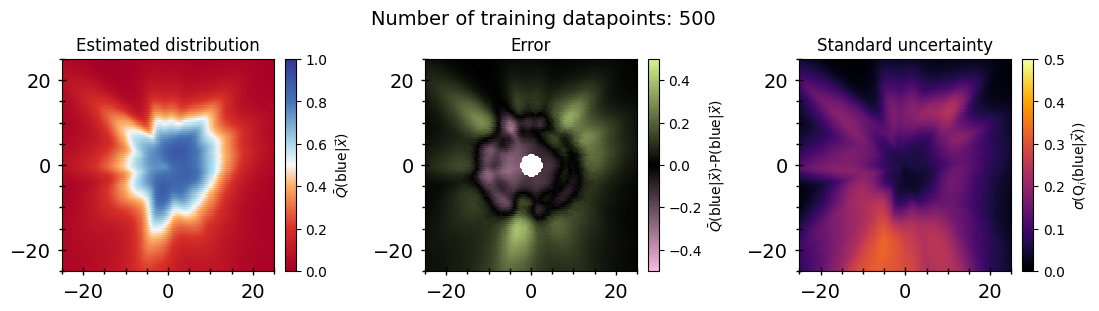

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_ensembles[i], truth_data, "Confidence_avg", "P_blue_given_x", axs[1], r"Error", max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), 
                 fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_ensembles[i], "Confidence_std", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/DNN_ensemble_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)

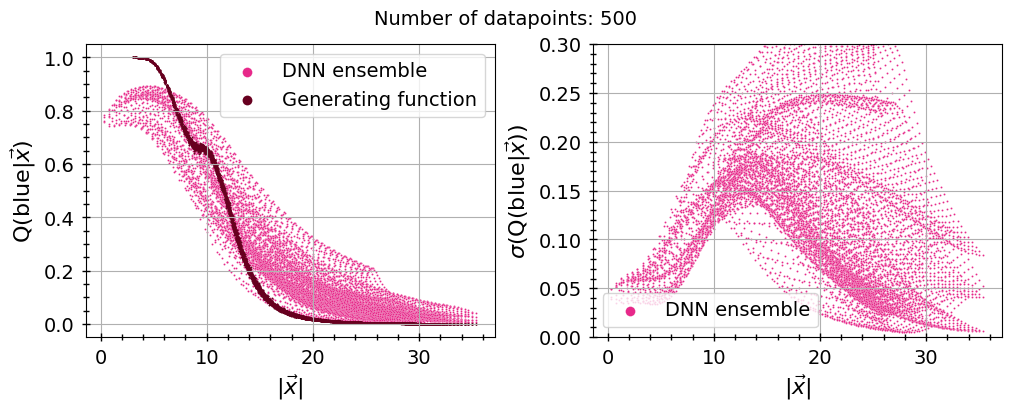

In [ ]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_avg", s=2, ax = axs[0], label="DNN ensemble", color="#e7298a")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_std", s=2, ax = axs[1], label="DNN ensemble", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)

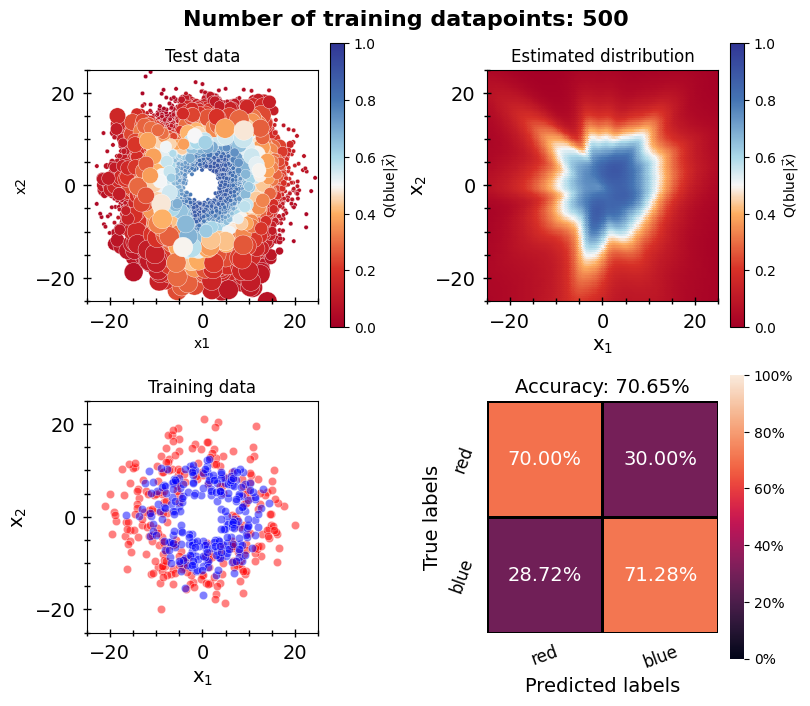

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_results(test_data_ensembles[i], "Confidence_avg", axs[0][0], "Test data", "Confidence_std")
    axs[0][1] = plot_grid(grid_ensembles[i], "Confidence_avg", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_data_ensembles[i], "class", "Prediction_ensemble", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


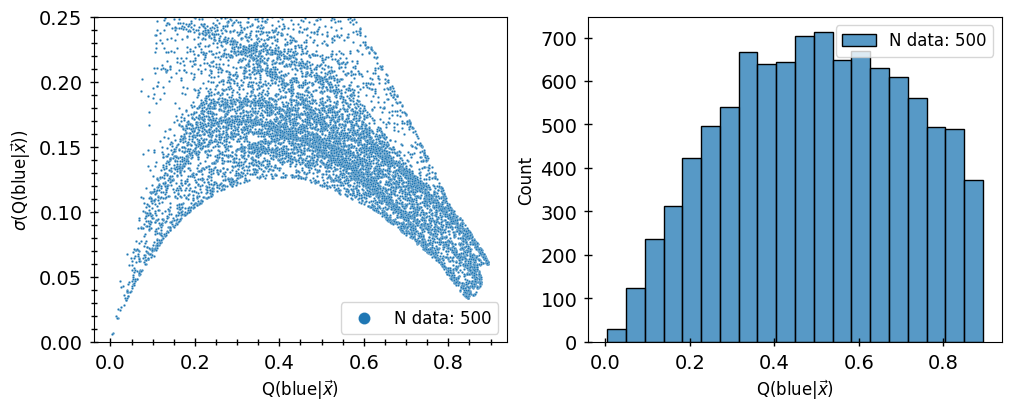

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_data_ensembles[i], x="Confidence_avg", y="Confidence_std", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_data_ensembles[i], x="Confidence_avg", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [ ]:
scores = calculate_metrics(test_data_ensembles, grid_ensembles, n_data, truth_data, truth_test_data, 
                           "Prediction_ensemble", "Confidence_avg", "Confidence_std")
scores.to_csv(f"predictions/{trainfile}/NNEscores.csv")
print(scores)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     500  0.7065  0.783691  0.067508  0.082425  0.147366  0.052911   

   Mean KL-div test  Mean KL-div grid   LogLoss      ECE       MCE     RMSCE  
0          0.033621          0.049025  0.561397  0.03872  0.112636  0.048368  


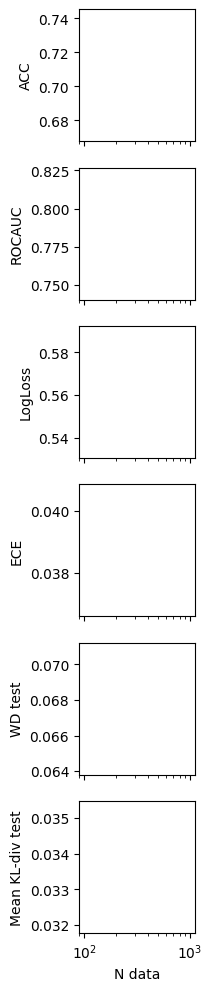

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[3])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[4])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[5])
for ax in axs:
    ax.set_xscale("log")

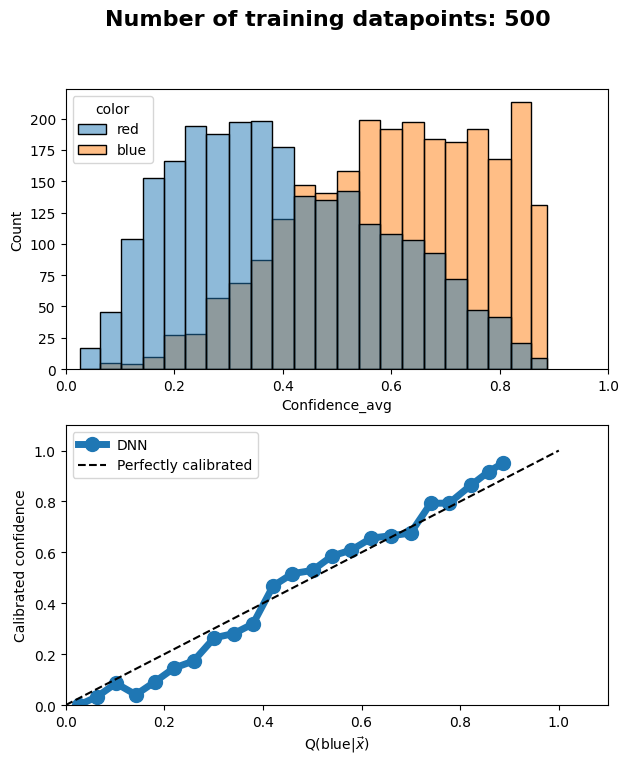

In [ ]:


#Get confidence for red
for i in range(len(n_data)):
    df = val_data_ensembles[i]
    prob_cal, prob_pred = calibration_curve(df["Truth"], df["Confidence_avg"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(val_data_ensembles[i], x="Confidence_avg", hue="color", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")